# Imports

In [9]:
import os
import pandas as pd

In [11]:
#csv_path = '../content/sample_data' # google colab path
csv_path = '../raw_data' # our pc path
cleandf = pd.read_csv(os.path.join(csv_path, 'clean_data.csv'))

In [12]:
cleandf

,Unnamed: 0,text,target
0,0,smell hillary fear daniel greenfield shillman ...,0
1,1,watch exact moment paul ryan commit political ...,0
2,2,kerry go paris gesture sympathy u secretary st...,1
3,3,bernie supporter twitter erupt anger dnc try w...,0
4,4,battle new york primary matter primary day new...,1
...,...,...,...
6330,6330,state department say can find email clinton sp...,1
6331,6331,p pb stand plutocratic pentagon p pb stand plu...,0
6332,6332,anti trump protester tool oligarchy informatio...,0
6333,6333,ethiopia obama seek progress peace security ea...,1


In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Flatten, Masking, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2022-08-24 14:57:09.578438: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-24 14:57:09.618871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 14:57:09.618961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Variables

In [14]:
es = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

In [15]:
binacc = BinaryAccuracy()
prec = Precision()
rec = Recall()

In [16]:
models = ['lstm', 'gru']
sizes = [0.3, 0.25, 0.2]

In [17]:
optimizers = [
    'adadelta', 
    'adagrad', 
    'adam', 
    'adamax', 
    'ftrl', 
    'nadam', 
    'rmsprop', 
    'sgd'
]

In [18]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01]
batches = [16, 32, 64]

# Functions

In [19]:
def plot_loss_accuracy(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{title} Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['binary_accuracy'])
    ax2.plot(history.history['val_binary_accuracy'])
    ax2.set_title(f'{title} Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_title(f'{title} Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=2)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)    
    
    ax4.plot(history.history['recall'])
    ax4.plot(history.history['val_recall'])
    ax4.set_title(f'{title} Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylim(ymin=0, ymax=2)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)  
    
    plt.show()

In [2]:
def initialize_model (model_name):
    model = Sequential()
    model.add(Embedding(
        input_dim=(len(tokenizer.word_index))+1, # +1 for the 0 padding
        input_length=300, # Max_sentence_length (optional, for model summary)
        output_dim=100,
        mask_zero=True, # Built-in masking layer :)
    ))
    if model_name == 'lstm':
        model.add(LSTM(50, return_sequences=False))
    if model_name == 'gru':
        model.add(GRU(50, return_sequences=False))
    #model.add(Conv1D(30, kernel_size=5, activation='tanh'))
    #model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [3]:
def compile_model(model, optimizer, learning_rate):
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    if optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer, 
              metrics=[binacc, prec, rec]) 
    
    return model

# Testing models

## LSTM model

### Testing best test and validation sizes

60/60 [==============================] - 1s 10ms/step - loss: 0.2897 - binary_accuracy: 0.9079 - precision: 0.9173 - recall: 0.9012


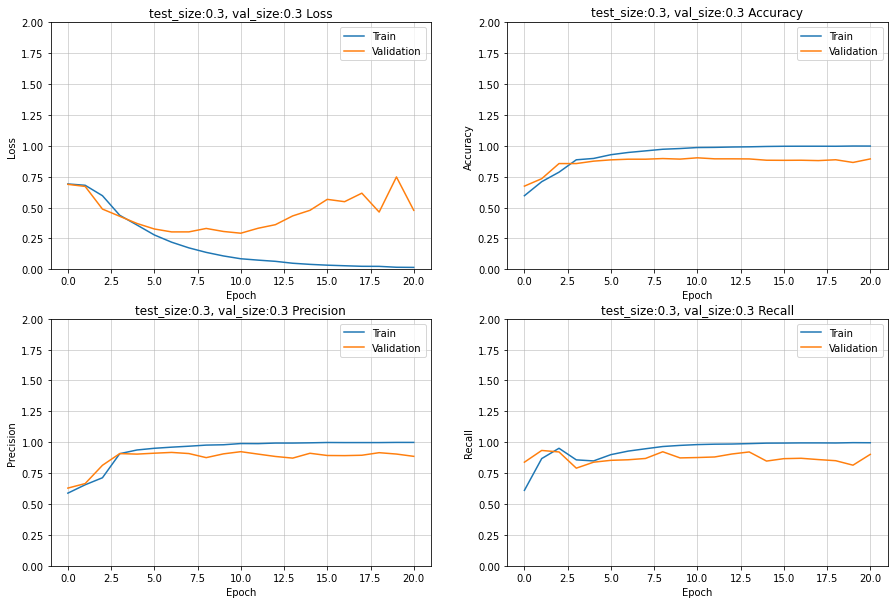

60/60 [==============================] - 1s 11ms/step - loss: 0.2757 - binary_accuracy: 0.9090 - precision: 0.9148 - recall: 0.9064


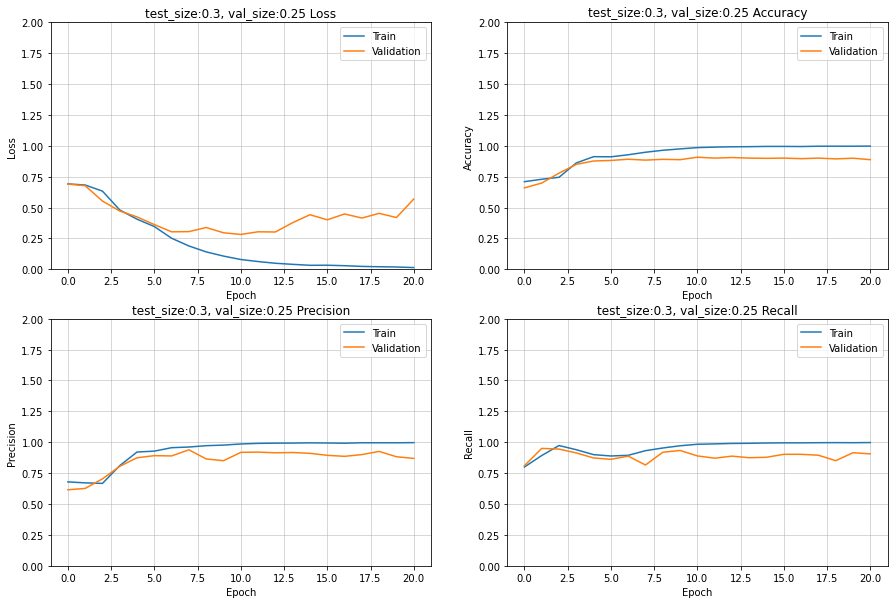

60/60 [==============================] - 0s 8ms/step - loss: 0.2820 - binary_accuracy: 0.9058 - precision: 0.9135 - recall: 0.9012


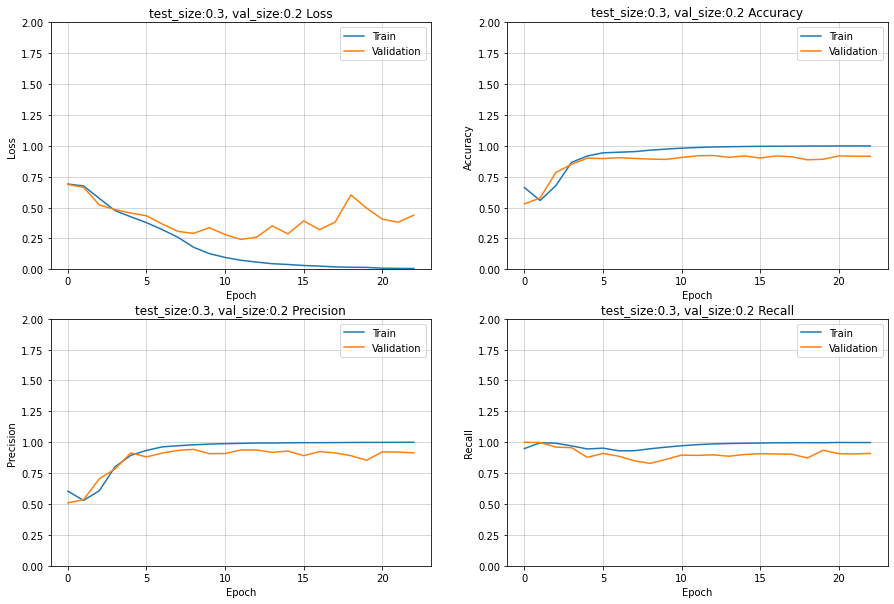

50/50 [==============================] - 1s 11ms/step - loss: 0.2936 - binary_accuracy: 0.9009 - precision: 0.9008 - recall: 0.8973


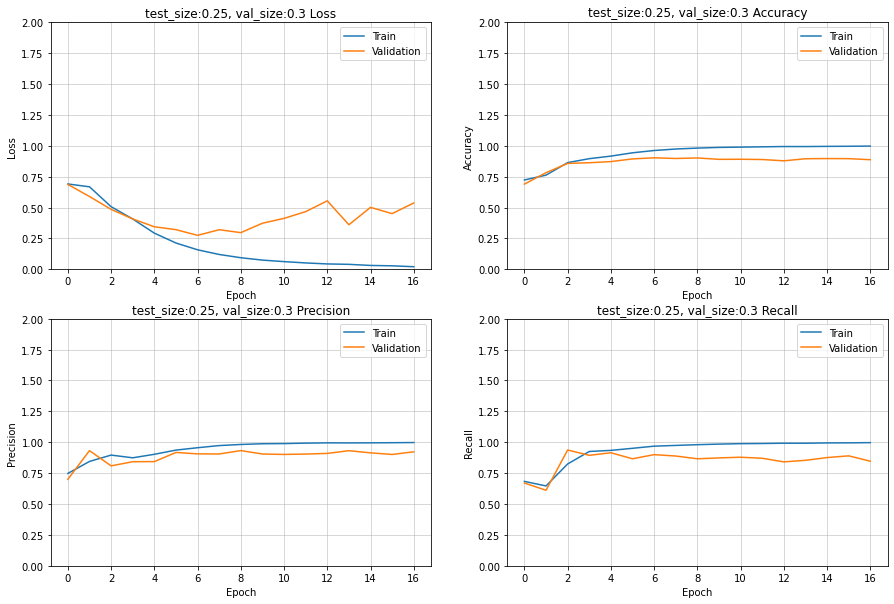

50/50 [==============================] - 1s 11ms/step - loss: 0.4702 - binary_accuracy: 0.8996 - precision: 0.9155 - recall: 0.8768


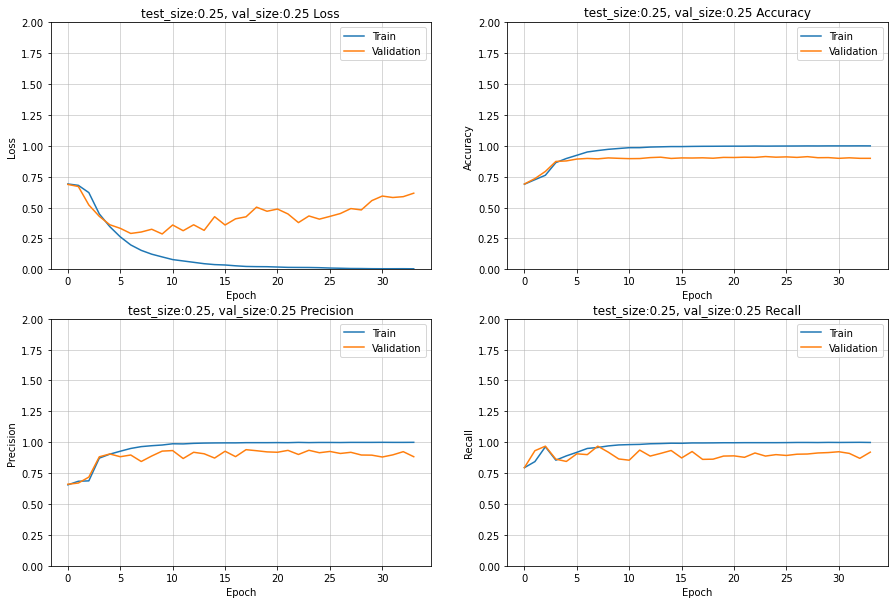

50/50 [==============================] - 0s 9ms/step - loss: 0.3064 - binary_accuracy: 0.8977 - precision: 0.9086 - recall: 0.8806


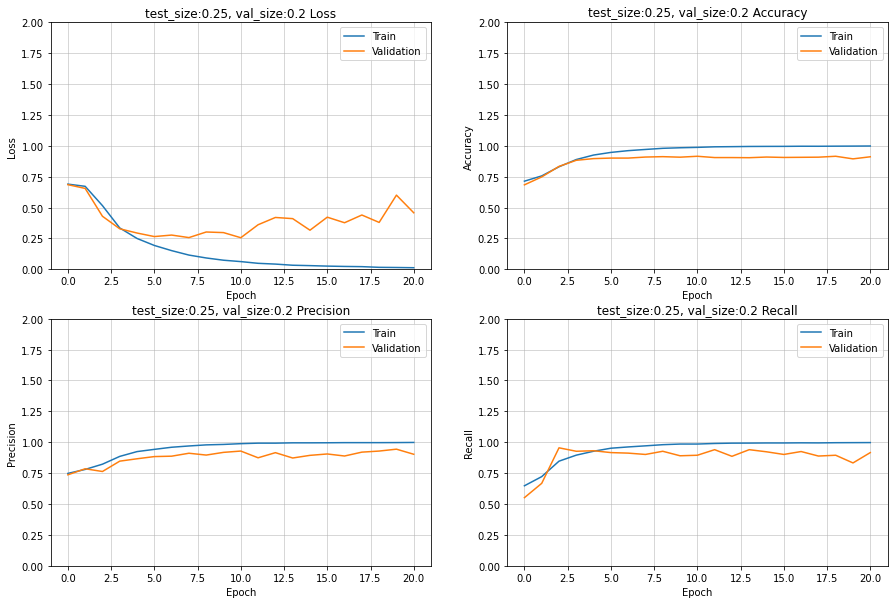

40/40 [==============================] - 0s 12ms/step - loss: 0.2333 - binary_accuracy: 0.9179 - precision: 0.9350 - recall: 0.8998


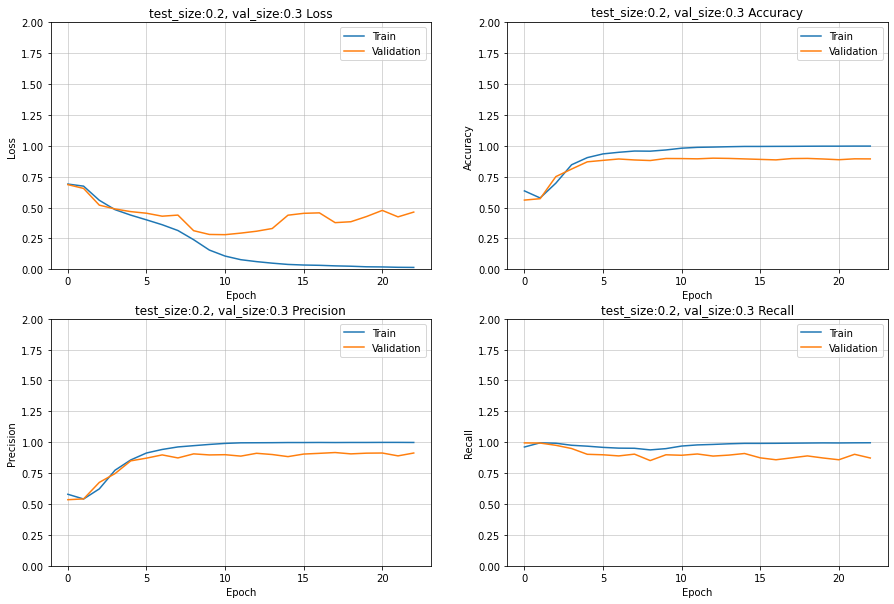

40/40 [==============================] - 0s 8ms/step - loss: 0.2651 - binary_accuracy: 0.9195 - precision: 0.9242 - recall: 0.9155


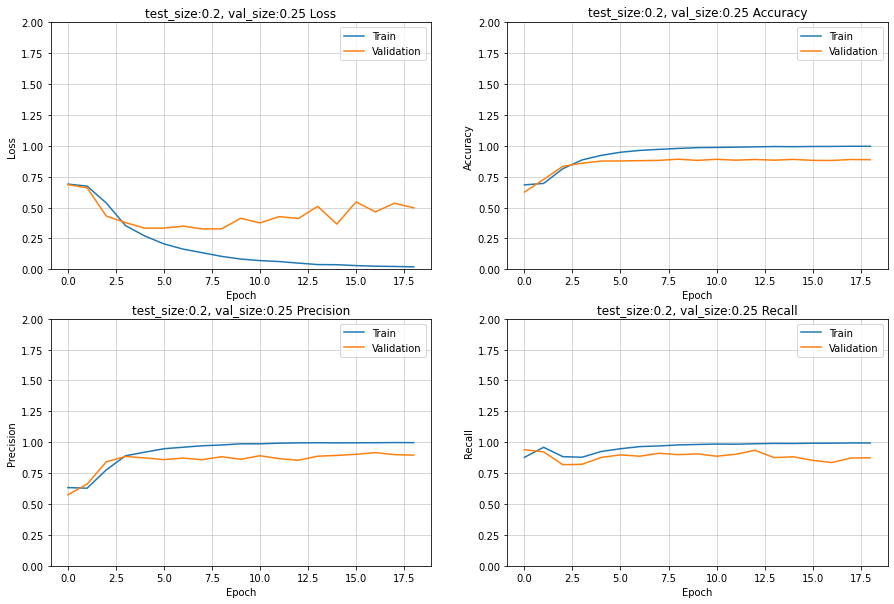

40/40 [==============================] - 0s 9ms/step - loss: 0.2752 - binary_accuracy: 0.9250 - precision: 0.9387 - recall: 0.9108


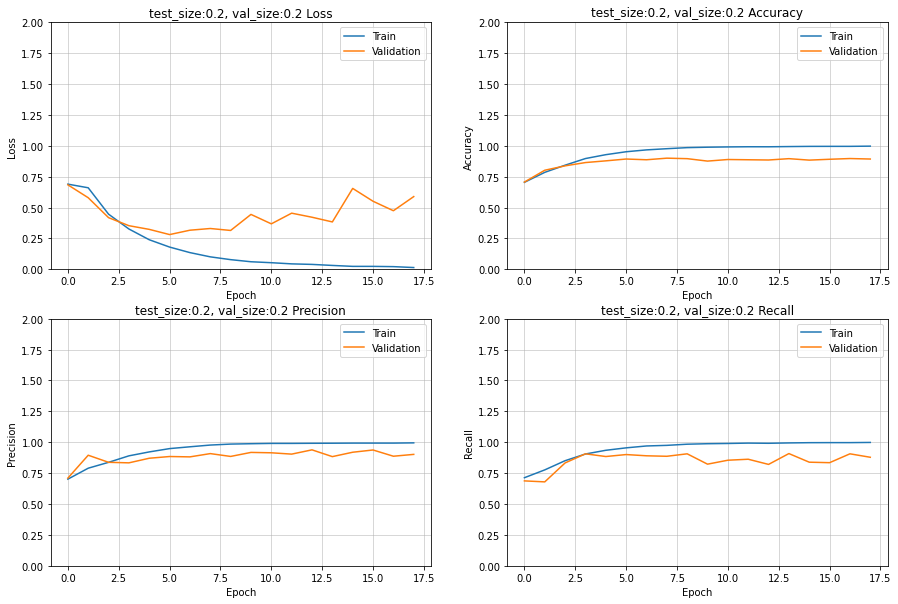

CPU times: user 9min 3s, sys: 35.5 s, total: 9min 39s
Wall time: 9min 24s


In [14]:
%%time
for test_size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=test_size)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
    X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)
    
    for val_size in sizes:
        model = compile_model(initialize_model('lstm'), 'rmsprop', 0.0001)
        history = model.fit(X_train_token, y_train, 
              epochs=50, 
              batch_size=32,
              validation_split=val_size,
              callbacks=[es],
            verbose = 0, 
            use_multiprocessing=True
             )
        model.summary()
        model.evaluate(X_test_token, y_test, verbose=1)
        plot_loss_accuracy(history, f'test_size:{test_size}, val_size:{val_size}') #, bs:{32}, mn:{lstm}, on:{rmsprop}, lr: {0.0001}')

#### Results:
##### Best test size: 0.2
##### Best val size: 0.2

In [26]:
tokenizer = Tokenizer()
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.2)

In [27]:
tokenizer.fit_on_texts(X_train)

In [28]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [29]:
X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)

### Testing best batch size

40/40 [==============================] - 0s 8ms/step - loss: 0.2759 - binary_accuracy: 0.9361 - precision: 0.9382 - recall: 0.9396


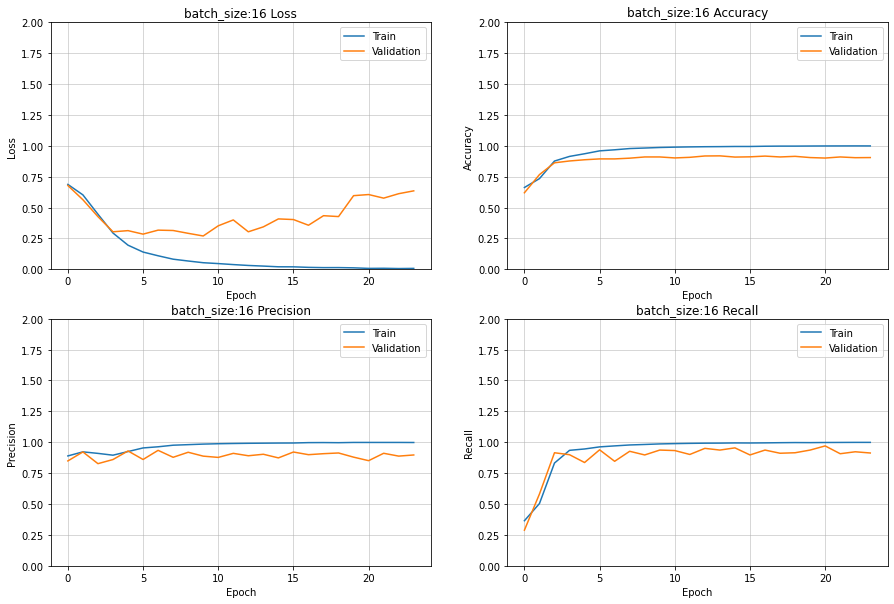

40/40 [==============================] - 0s 8ms/step - loss: 0.4890 - binary_accuracy: 0.9132 - precision: 0.9207 - recall: 0.9124


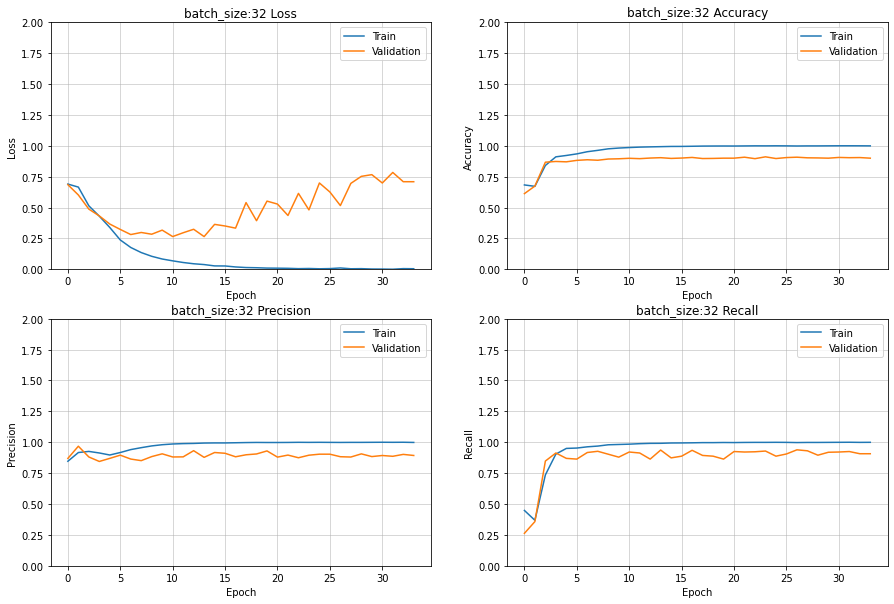

40/40 [==============================] - 0s 8ms/step - loss: 0.3820 - binary_accuracy: 0.9069 - precision: 0.9373 - recall: 0.8807


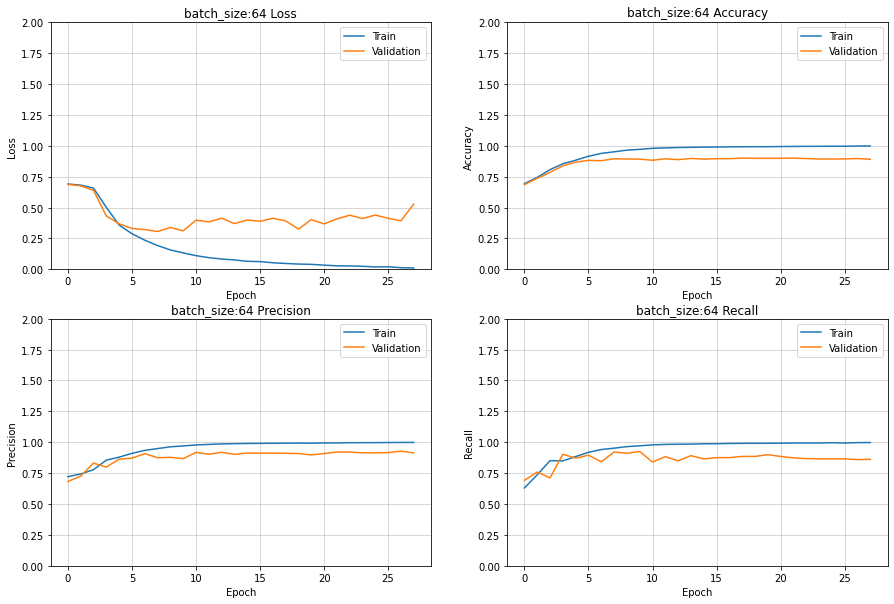

CPU times: user 4min 36s, sys: 18.6 s, total: 4min 55s
Wall time: 3min 49s


In [19]:
%%time
for batch_size in batches:
    model = compile_model(initialize_model('lstm'), 'rmsprop', 0.0001)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=batch_size,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'batch_size:{batch_size}') #, mn:{lstm}, on:{rmsprop}, lr: {0.0001}')

#### Result:
##### Best batch size: 16

### Testing best optimizer

40/40 [==============================] - 0s 8ms/step - loss: 0.6914 - binary_accuracy: 0.5951 - precision: 0.6568 - recall: 0.4713


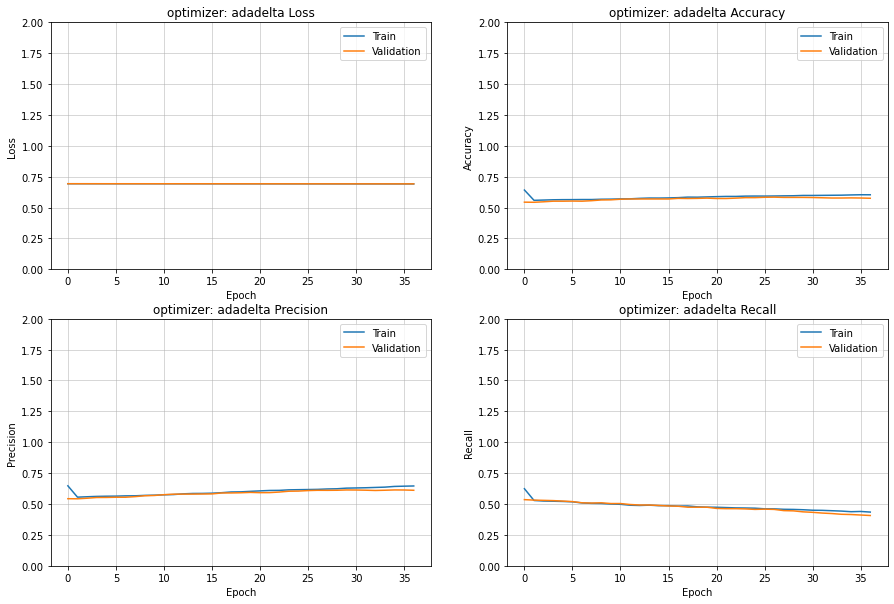

40/40 [==============================] - 0s 8ms/step - loss: 0.6929 - binary_accuracy: 0.5099 - precision: 0.6228 - recall: 0.1571


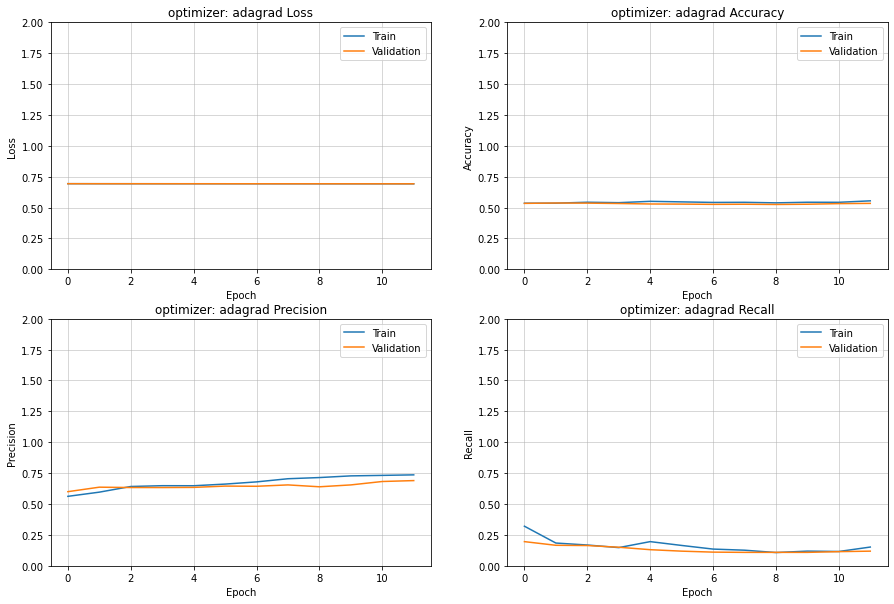

40/40 [==============================] - 0s 11ms/step - loss: 0.2636 - binary_accuracy: 0.9108 - precision: 0.9178 - recall: 0.9109


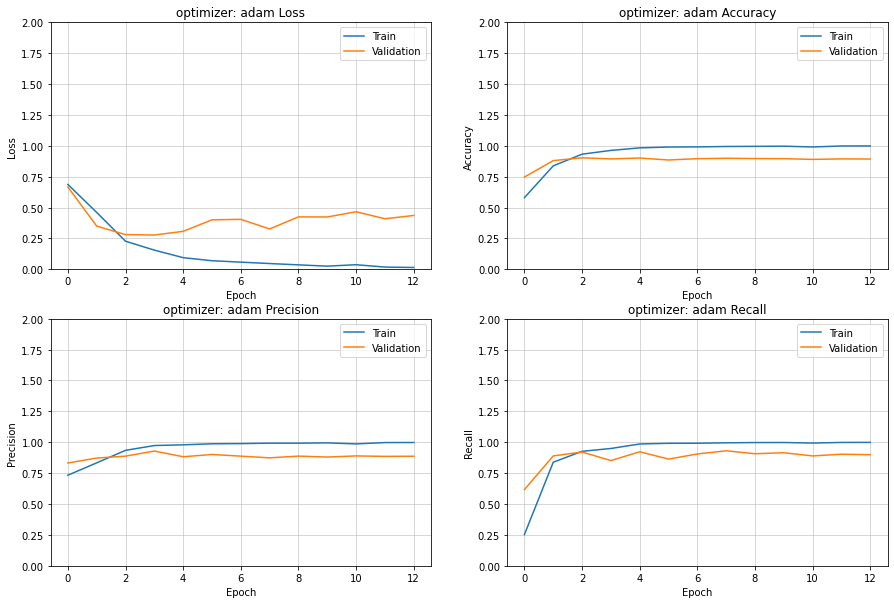

40/40 [==============================] - 0s 11ms/step - loss: 0.2128 - binary_accuracy: 0.9171 - precision: 0.9291 - recall: 0.9109


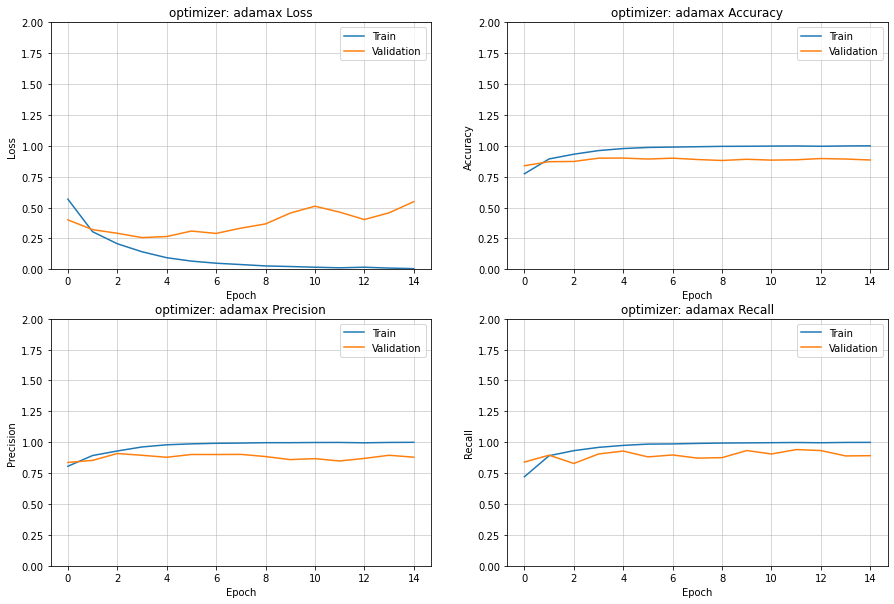

40/40 [==============================] - 0s 8ms/step - loss: 0.6932 - binary_accuracy: 0.4775 - precision: 0.0000e+00 - recall: 0.0000e+00


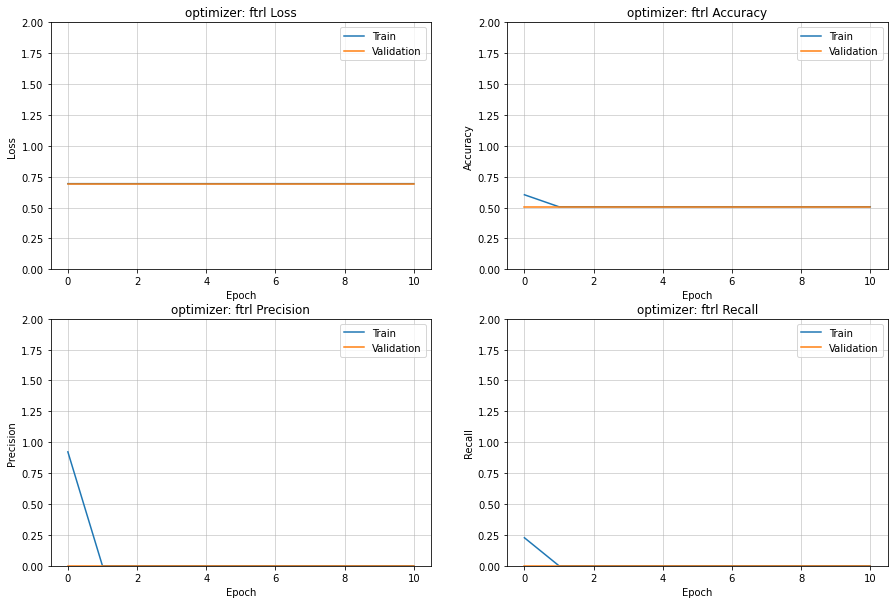

40/40 [==============================] - 0s 11ms/step - loss: 0.4809 - binary_accuracy: 0.8950 - precision: 0.9114 - recall: 0.8852


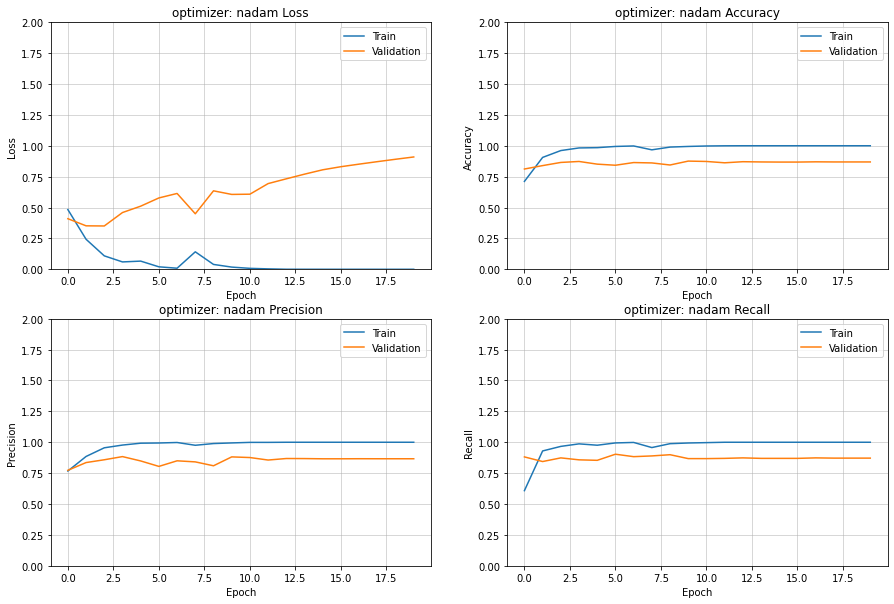

40/40 [==============================] - 0s 8ms/step - loss: 0.3232 - binary_accuracy: 0.9195 - precision: 0.9389 - recall: 0.9048


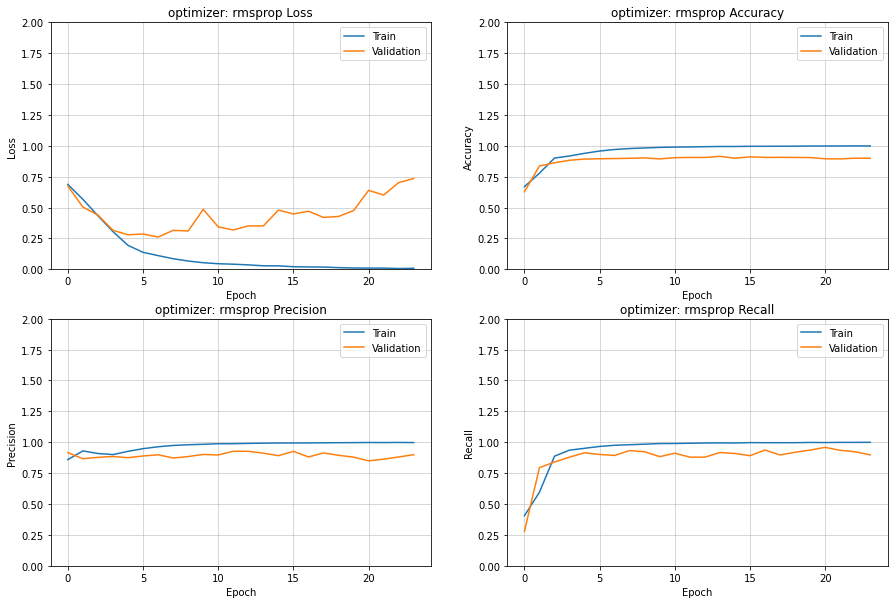

40/40 [==============================] - 0s 9ms/step - loss: 0.2982 - binary_accuracy: 0.8729 - precision: 0.9047 - recall: 0.8459


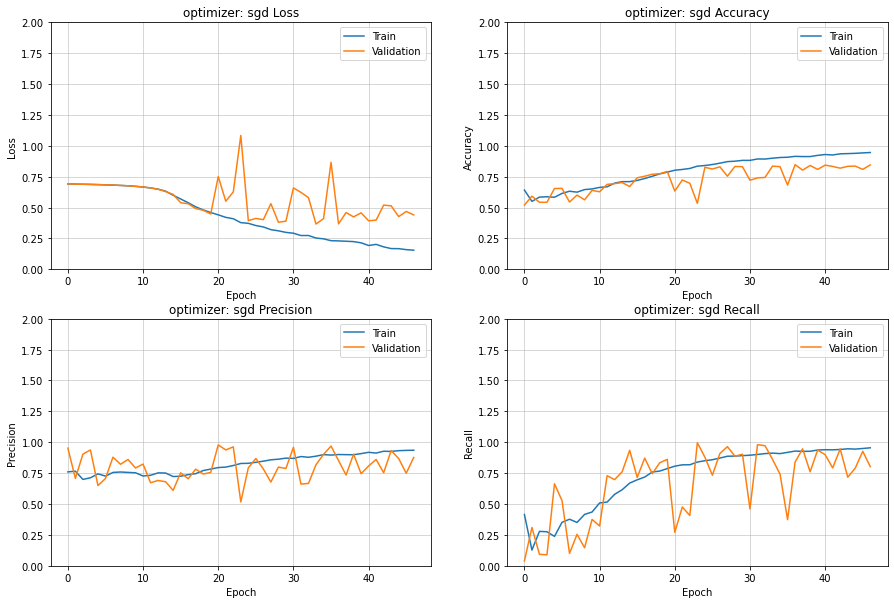

CPU times: user 16min 29s, sys: 1min 1s, total: 17min 30s
Wall time: 15min


In [22]:
%%time
for optimizer in optimizers:
    model = compile_model(initialize_model('lstm'), optimizer, 0.0001)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'optimizer: {optimizer}')

#### Results:
##### Best optimizers: Adamax and RMSprop

### Testing best learning rate on both optimizers

40/40 [==============================] - 0s 11ms/step - loss: 0.2795 - binary_accuracy: 0.9140 - precision: 0.9128 - recall: 0.9171


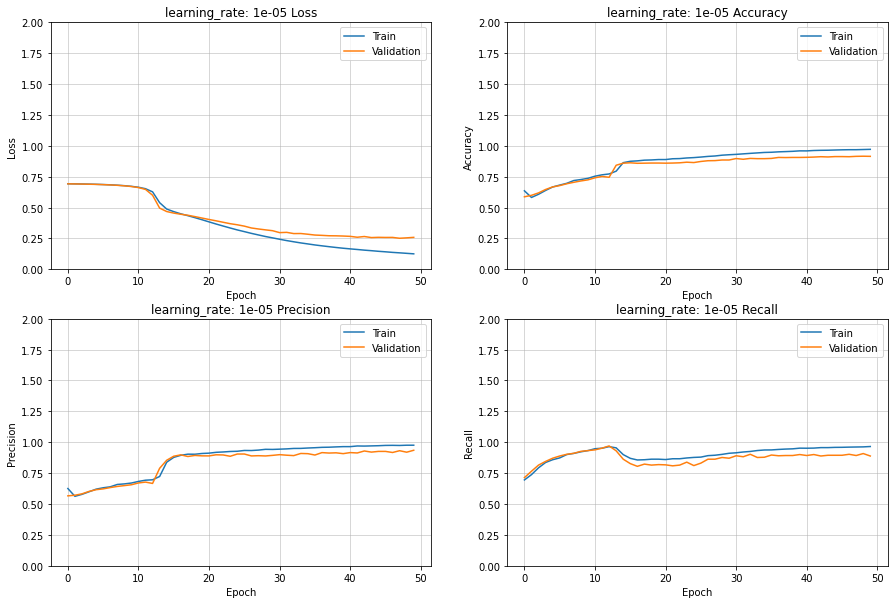

40/40 [==============================] - 0s 11ms/step - loss: 0.2356 - binary_accuracy: 0.9227 - precision: 0.9043 - recall: 0.9468


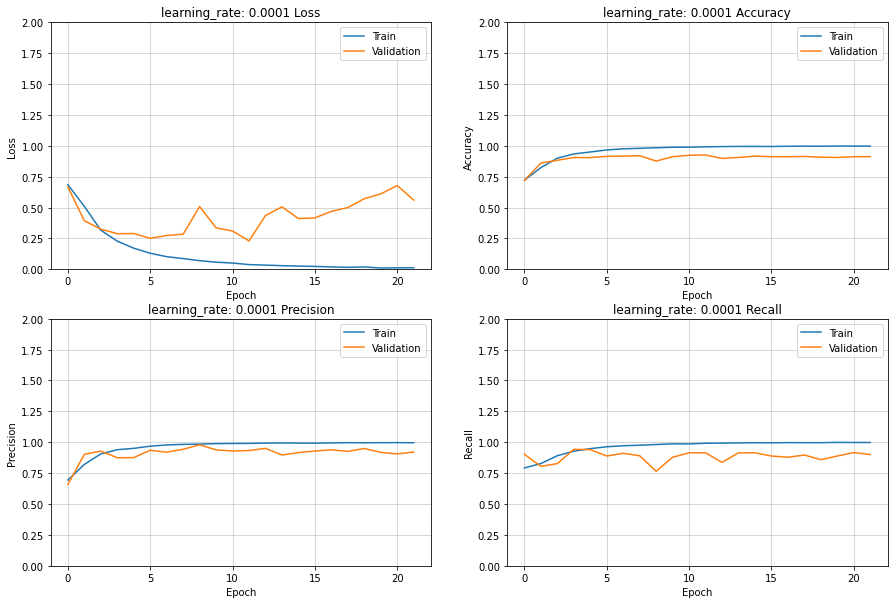

40/40 [==============================] - 0s 8ms/step - loss: 0.2811 - binary_accuracy: 0.9092 - precision: 0.8946 - recall: 0.9296


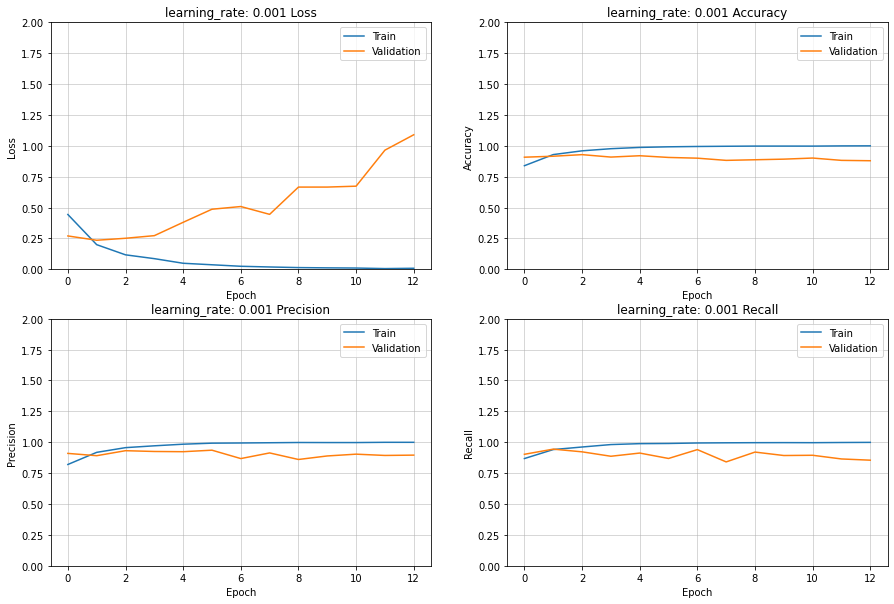

40/40 [==============================] - 0s 8ms/step - loss: 0.2960 - binary_accuracy: 0.9037 - precision: 0.9097 - recall: 0.8983


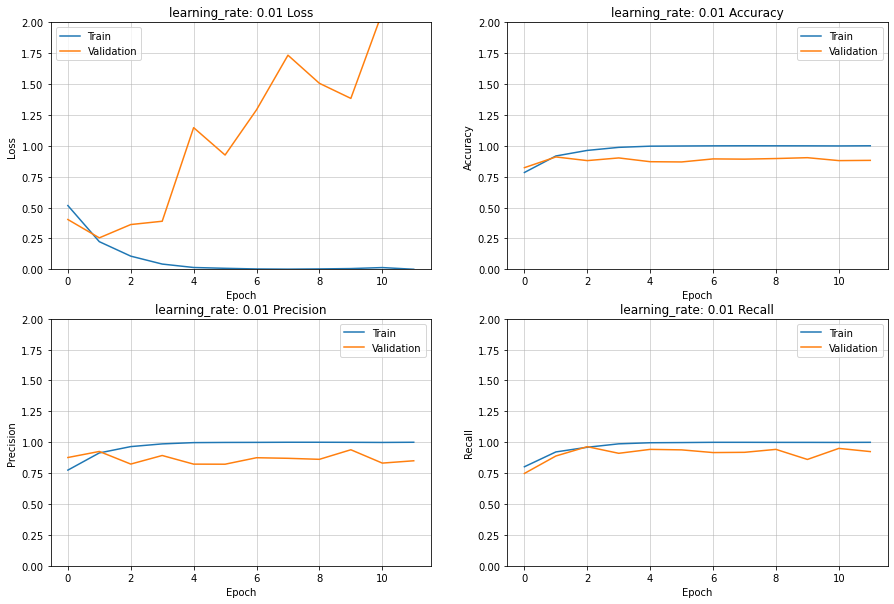

CPU times: user 9min 5s, sys: 36.5 s, total: 9min 42s
Wall time: 8min 57s


In [30]:
%%time
for learning_rate in learning_rates:
    model = compile_model(initialize_model('lstm'), 'rmsprop', learning_rate)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'learning_rate: {learning_rate}')

40/40 [==============================] - 0s 10ms/step - loss: 0.2992 - binary_accuracy: 0.9045 - precision: 0.9177 - recall: 0.8905


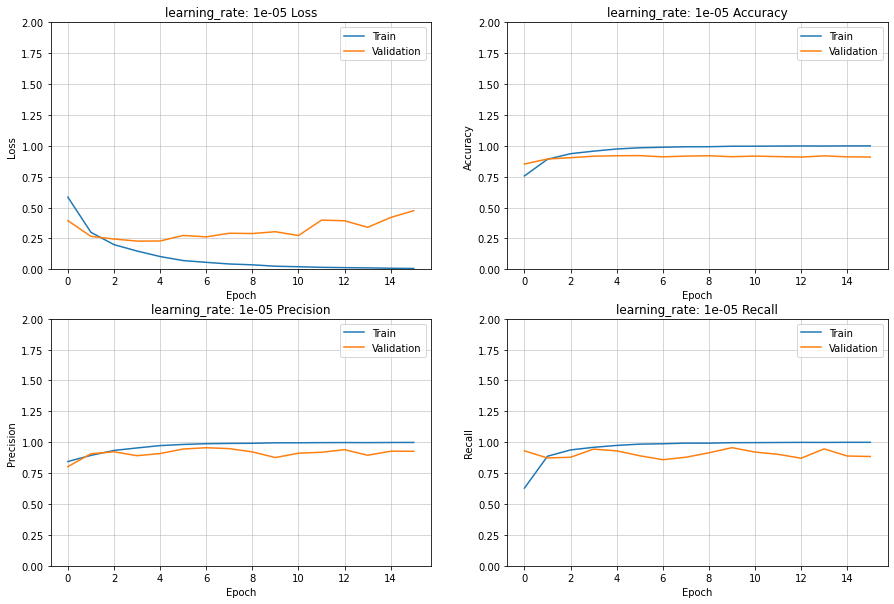

40/40 [==============================] - 0s 11ms/step - loss: 0.3412 - binary_accuracy: 0.9061 - precision: 0.8801 - recall: 0.9421


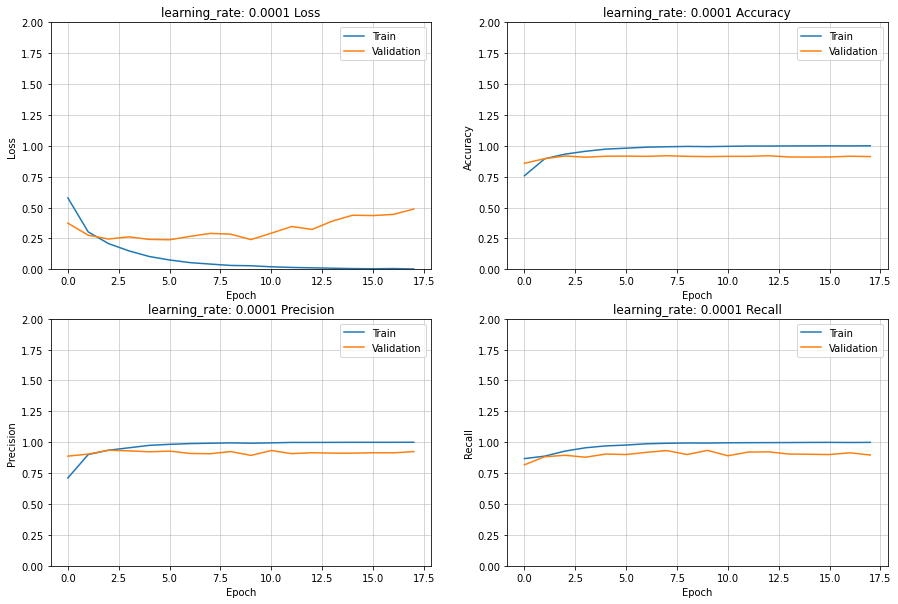

40/40 [==============================] - 0s 8ms/step - loss: 0.4471 - binary_accuracy: 0.9069 - precision: 0.9077 - recall: 0.9077


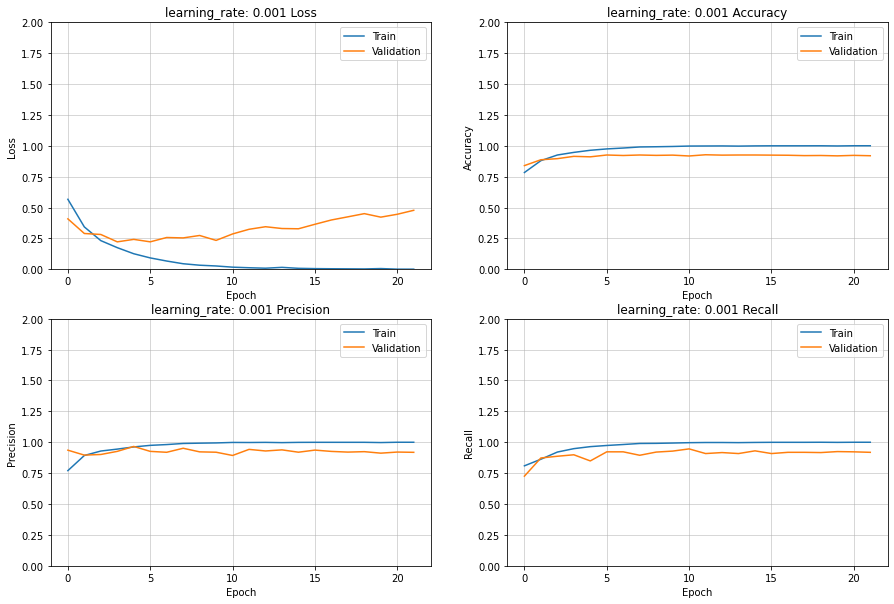

40/40 [==============================] - 0s 8ms/step - loss: 0.2568 - binary_accuracy: 0.9021 - precision: 0.8907 - recall: 0.9186


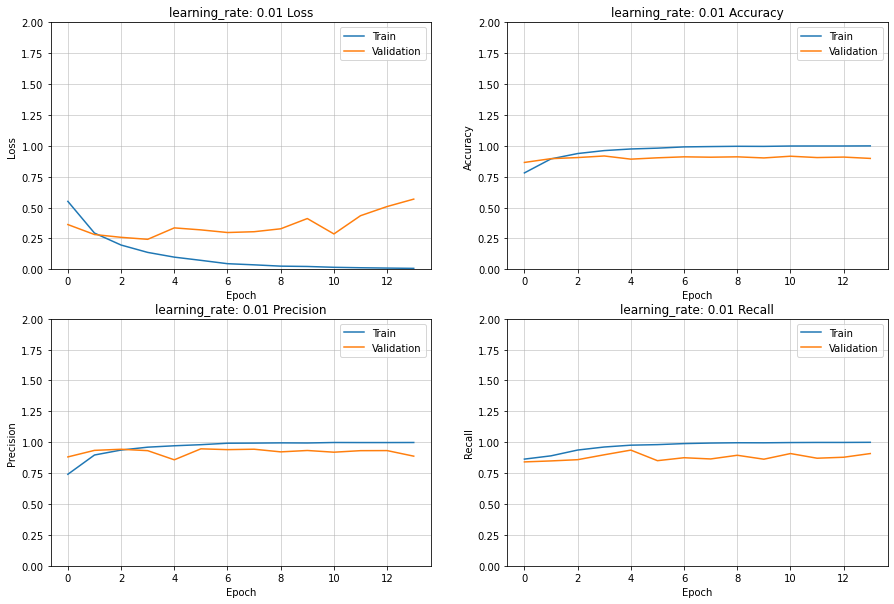

CPU times: user 6min 32s, sys: 25.2 s, total: 6min 57s
Wall time: 5min 41s


In [31]:
%%time
for learning_rate in learning_rates:
    model = compile_model(initialize_model('lstm'), 'adamax', learning_rate)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'learning_rate: {learning_rate}')

#### Results:
##### Best learning rate: 0.0001
###### Best optimizer: rmsprop

## GRU model

### Testing best test and validation sizes

60/60 [==============================] - 1s 10ms/step - loss: 0.2838 - binary_accuracy: 0.9132 - precision: 0.9082 - recall: 0.9169


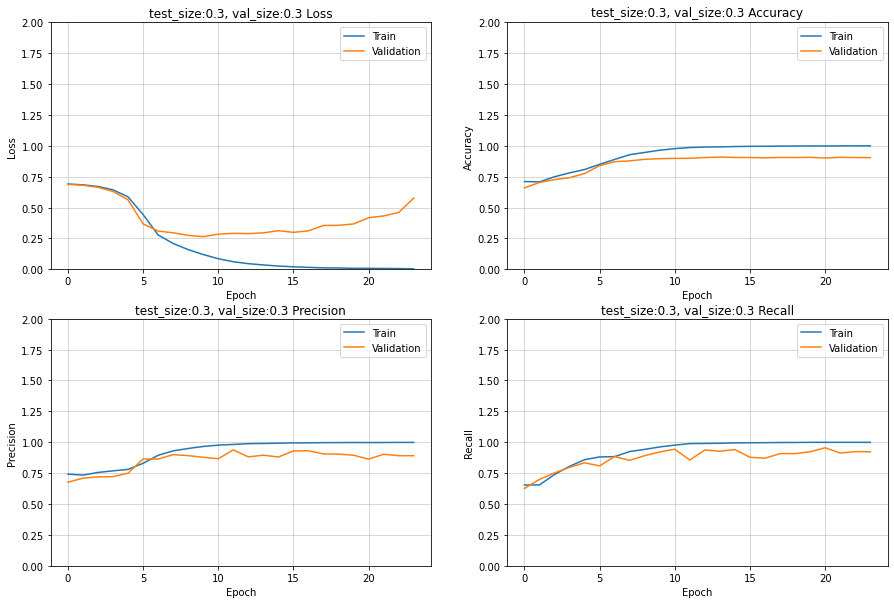

60/60 [==============================] - 0s 8ms/step - loss: 0.3575 - binary_accuracy: 0.8985 - precision: 0.8968 - recall: 0.8978


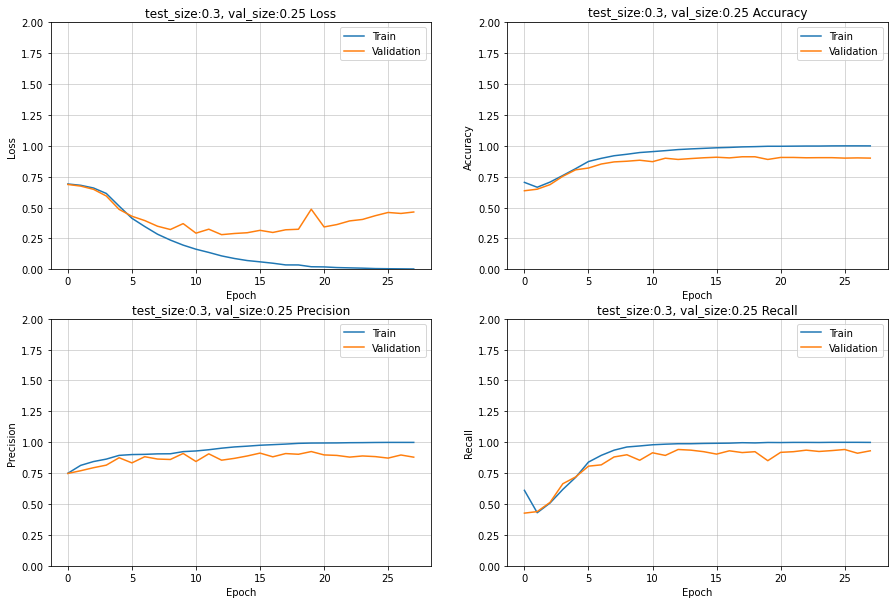

60/60 [==============================] - 1s 10ms/step - loss: 0.3963 - binary_accuracy: 0.9095 - precision: 0.9050 - recall: 0.9127


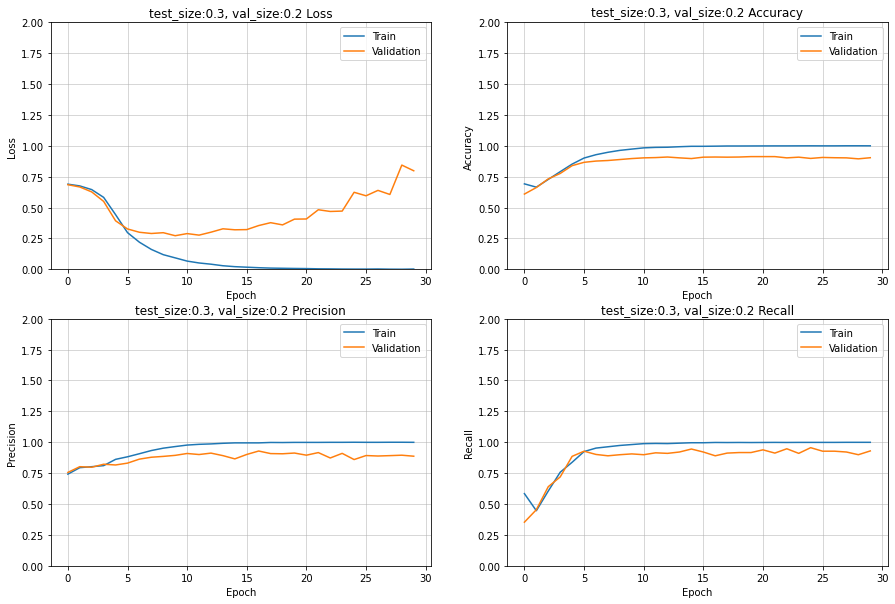

50/50 [==============================] - 0s 8ms/step - loss: 0.3902 - binary_accuracy: 0.9034 - precision: 0.9137 - recall: 0.8918


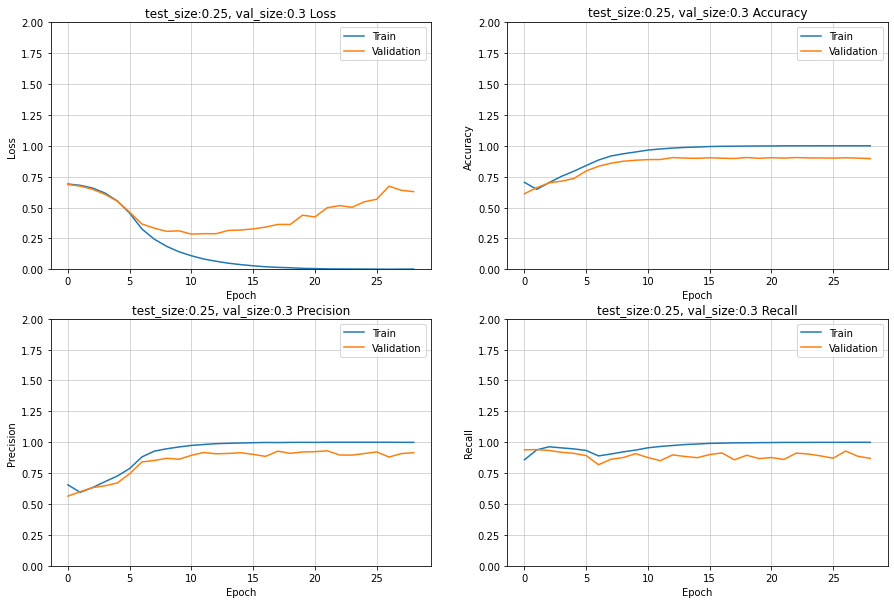

50/50 [==============================] - 1s 11ms/step - loss: 0.3841 - binary_accuracy: 0.9066 - precision: 0.9132 - recall: 0.8994


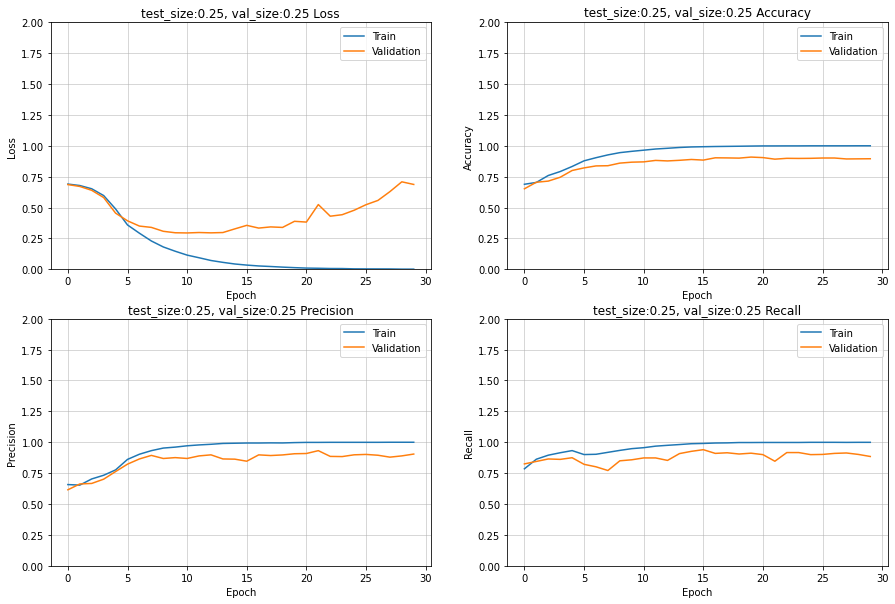

50/50 [==============================] - 0s 8ms/step - loss: 0.3913 - binary_accuracy: 0.9129 - precision: 0.9071 - recall: 0.9208


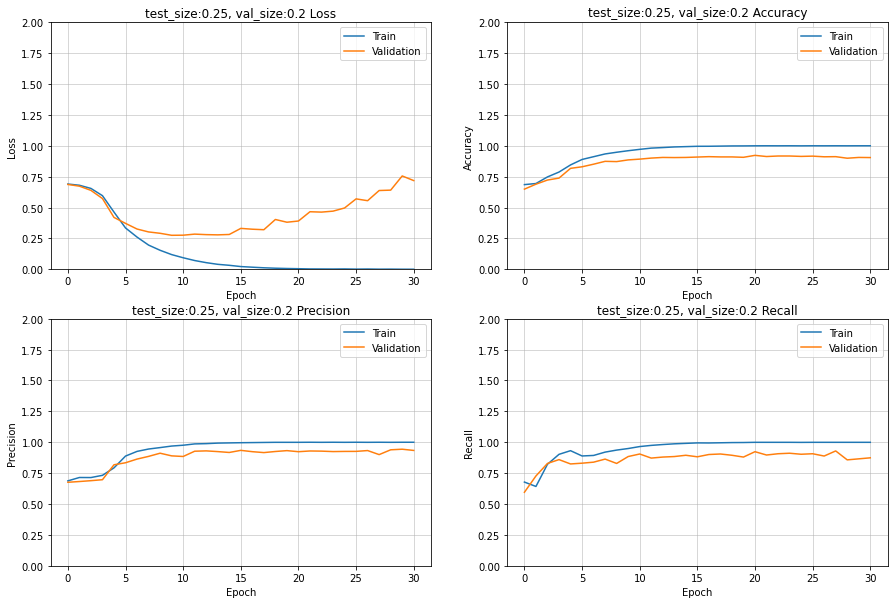

40/40 [==============================] - 0s 8ms/step - loss: 0.4213 - binary_accuracy: 0.9021 - precision: 0.8938 - recall: 0.9135


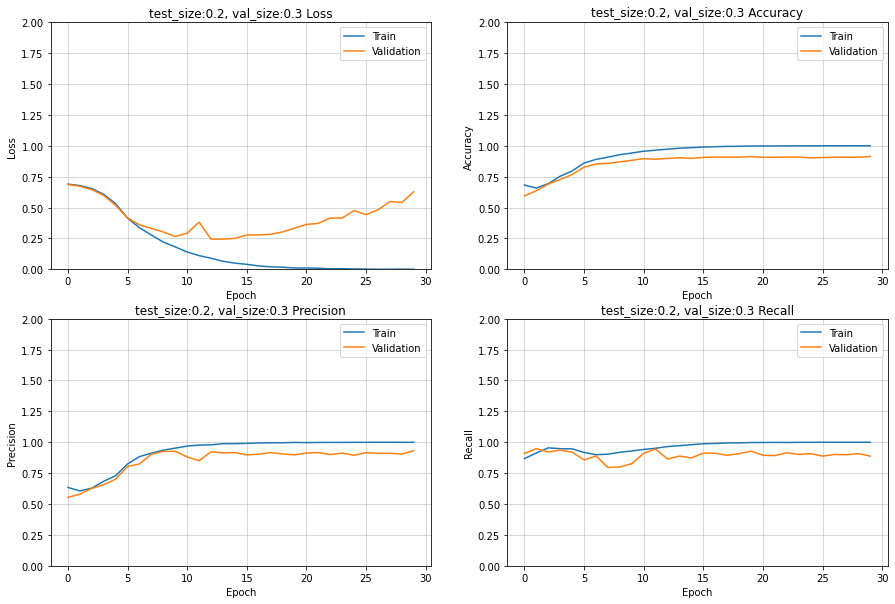

40/40 [==============================] - 0s 9ms/step - loss: 0.3775 - binary_accuracy: 0.8792 - precision: 0.8756 - recall: 0.8852


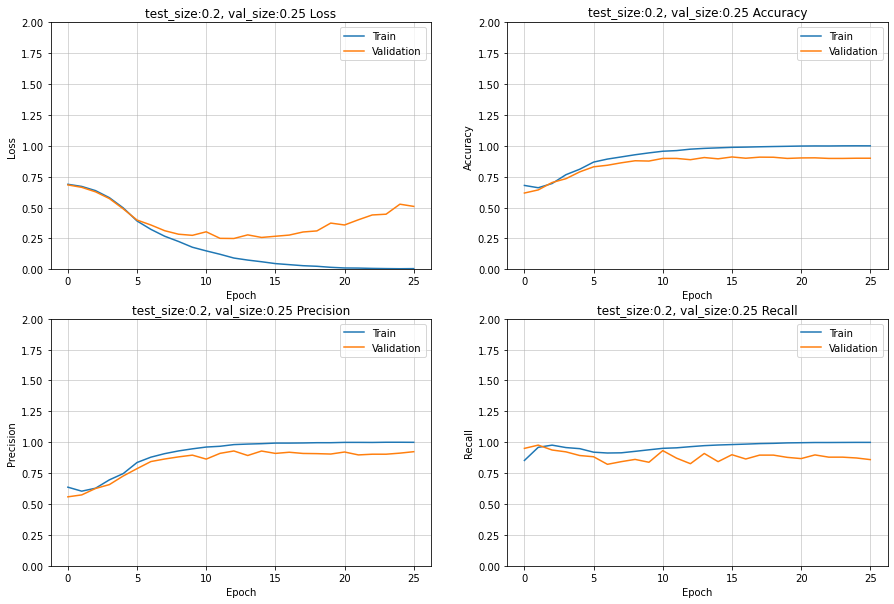

40/40 [==============================] - 0s 8ms/step - loss: 0.4244 - binary_accuracy: 0.9053 - precision: 0.9216 - recall: 0.8868


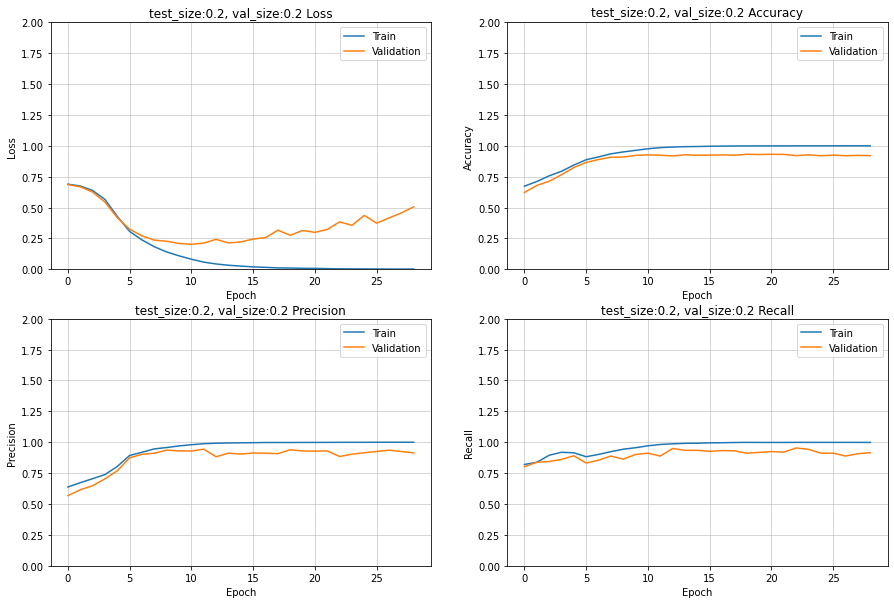

CPU times: user 11min 6s, sys: 43.5 s, total: 11min 49s
Wall time: 10min 44s


In [40]:
%%time
for test_size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=test_size)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
    X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)
    
    for val_size in sizes:
        model = compile_model(initialize_model('gru'), 'rmsprop', 0.0001)
        history = model.fit(X_train_token, y_train, 
              epochs=50, 
              batch_size=32,
              validation_split=val_size,
              callbacks=[es],
            verbose = 0, 
            use_multiprocessing=True
             )
        model.evaluate(X_test_token, y_test, verbose=1)
        plot_loss_accuracy(history, f'test_size:{test_size}, val_size:{val_size}') #, bs:{32}, mn:{lstm}, on:{rmsprop}, lr: {0.0001}')

#### Results:
##### Best test size: 0.3
##### Best val size: 0.3

In [41]:
tokenizer = Tokenizer()
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.3)

In [42]:
tokenizer.fit_on_texts(X_train)

In [43]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [44]:
X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)

### Testing best batch size

60/60 [==============================] - 1s 10ms/step - loss: 0.8014 - binary_accuracy: 0.9074 - precision: 0.8957 - recall: 0.9254


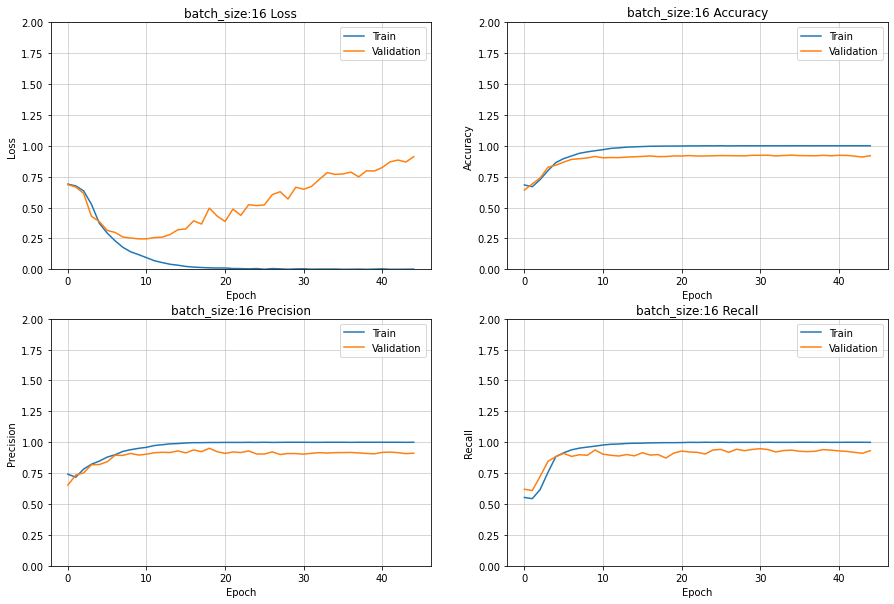

60/60 [==============================] - 1s 10ms/step - loss: 0.3111 - binary_accuracy: 0.9116 - precision: 0.9070 - recall: 0.9202


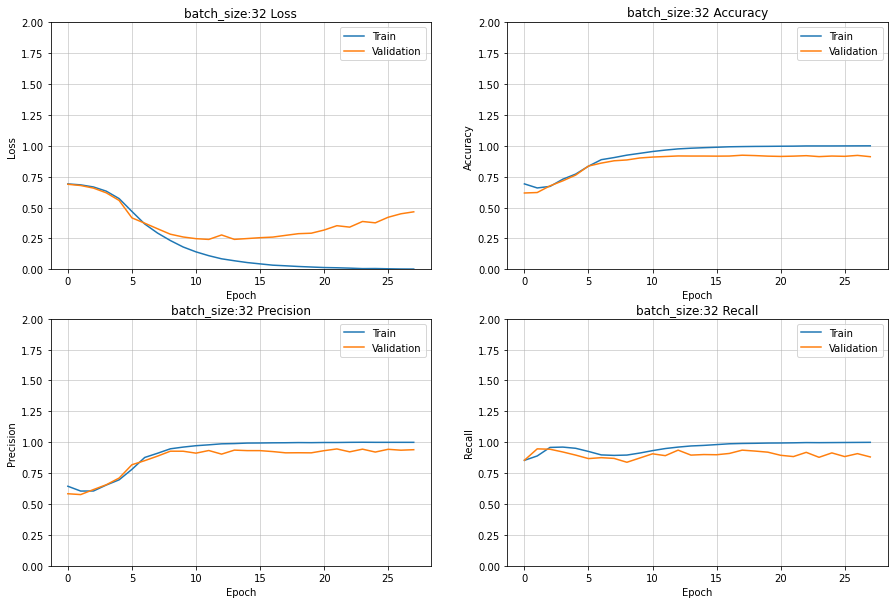

60/60 [==============================] - 1s 8ms/step - loss: 0.5295 - binary_accuracy: 0.9048 - precision: 0.8881 - recall: 0.9295


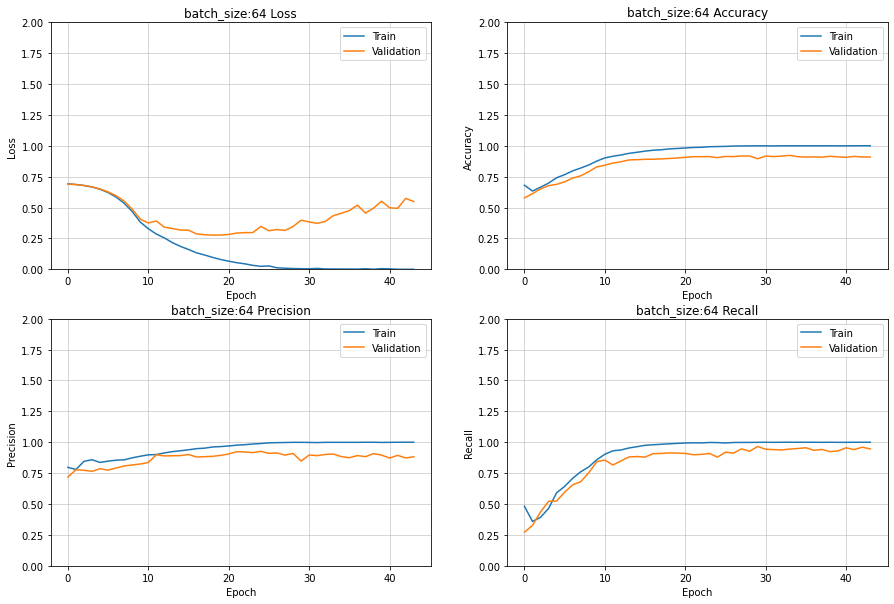

CPU times: user 5min 23s, sys: 21 s, total: 5min 44s
Wall time: 5min 43s


In [45]:
%%time
for batch_size in batches:
    model = compile_model(initialize_model('gru'), 'rmsprop', 0.0001)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=batch_size,
          validation_split=0.3,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'batch_size:{batch_size}') #, mn:{lstm}, on:{rmsprop}, lr: {0.0001}')

#### Result:
##### Best batch size: 32

### Testing best optimizer

60/60 [==============================] - 1s 10ms/step - loss: 0.6931 - binary_accuracy: 0.5097 - precision: 0.5141 - recall: 0.6218


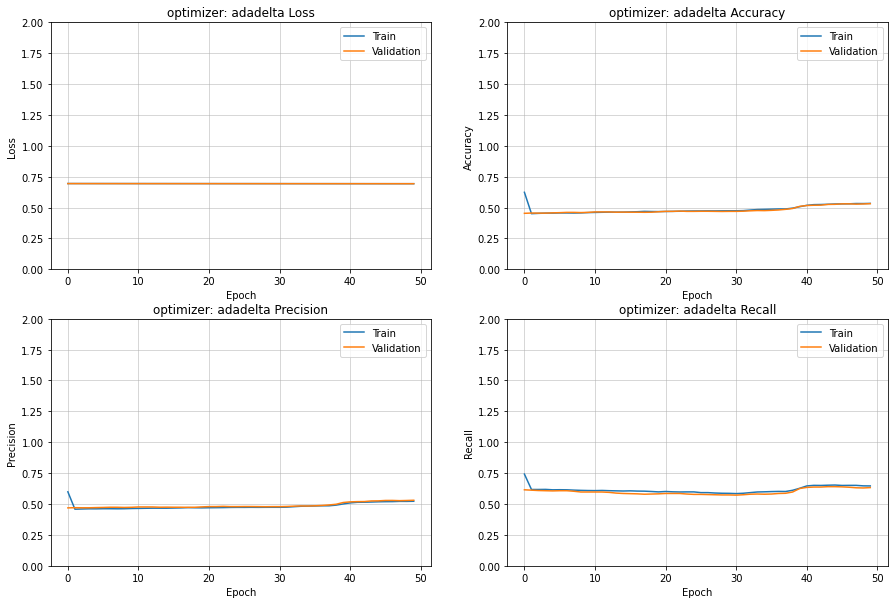

60/60 [==============================] - 0s 8ms/step - loss: 0.6898 - binary_accuracy: 0.5318 - precision: 0.9630 - recall: 0.0808


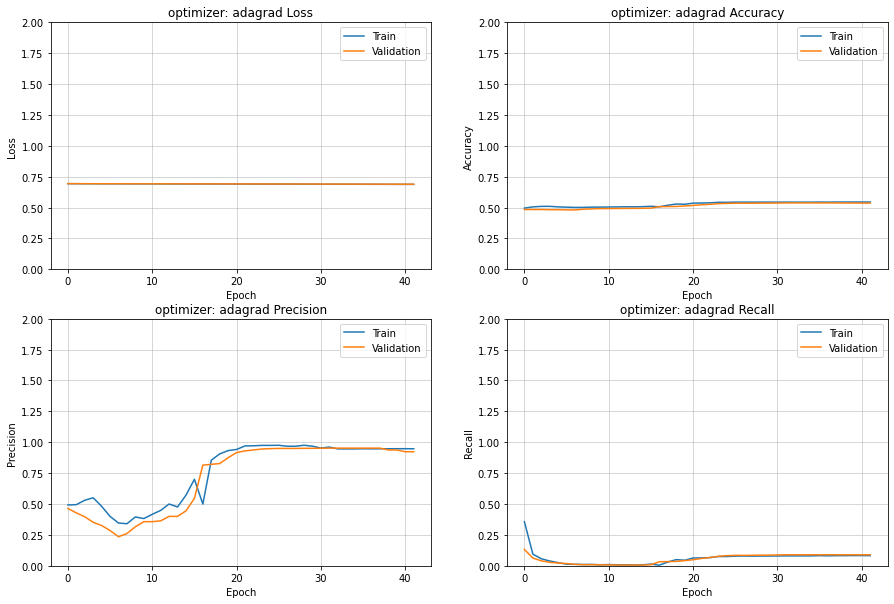

60/60 [==============================] - 1s 10ms/step - loss: 0.3860 - binary_accuracy: 0.9027 - precision: 0.8971 - recall: 0.9130


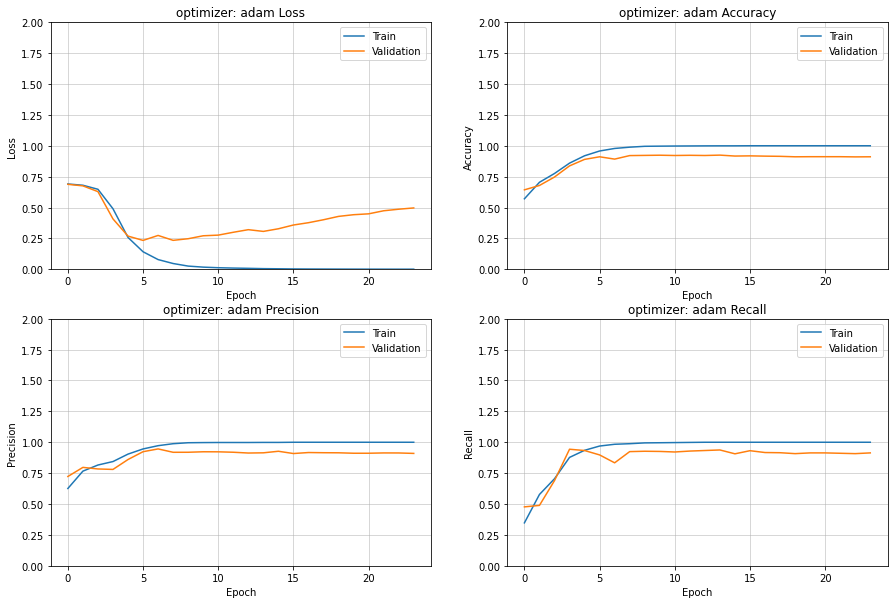

60/60 [==============================] - 1s 10ms/step - loss: 0.6231 - binary_accuracy: 0.9006 - precision: 0.8903 - recall: 0.9171


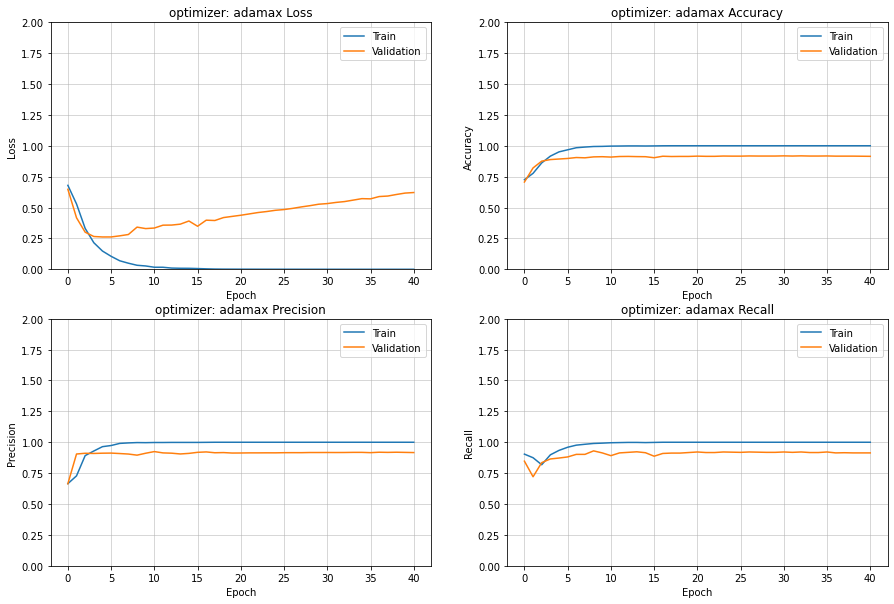

60/60 [==============================] - 0s 8ms/step - loss: 0.6932 - binary_accuracy: 0.4924 - precision: 0.0000e+00 - recall: 0.0000e+00


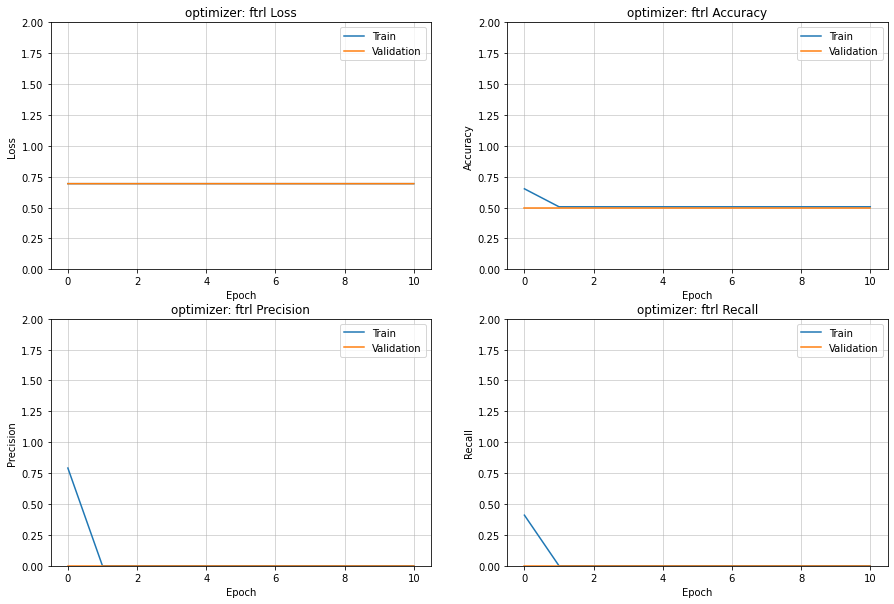

60/60 [==============================] - 1s 10ms/step - loss: 0.6286 - binary_accuracy: 0.8801 - precision: 0.8933 - recall: 0.8674


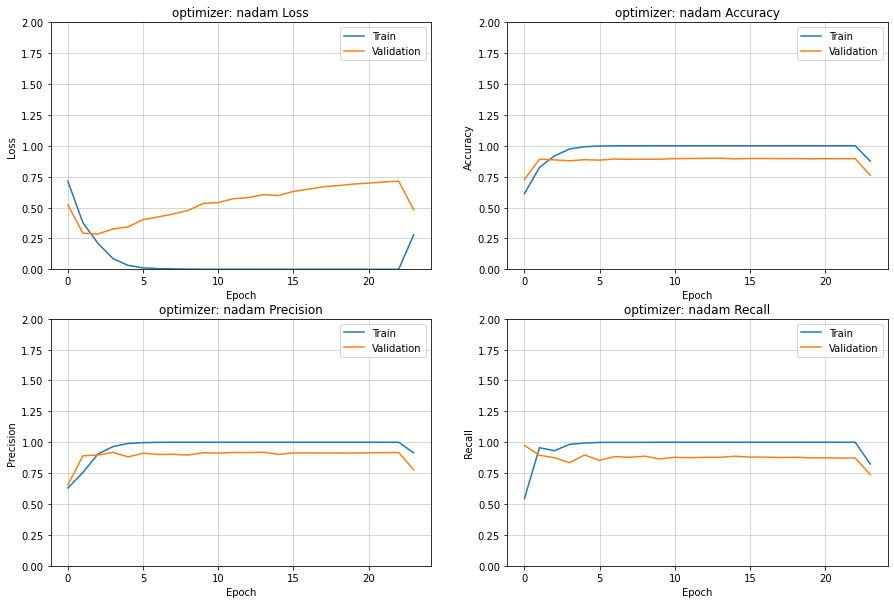

60/60 [==============================] - 1s 10ms/step - loss: 0.5276 - binary_accuracy: 0.9122 - precision: 0.9122 - recall: 0.9150


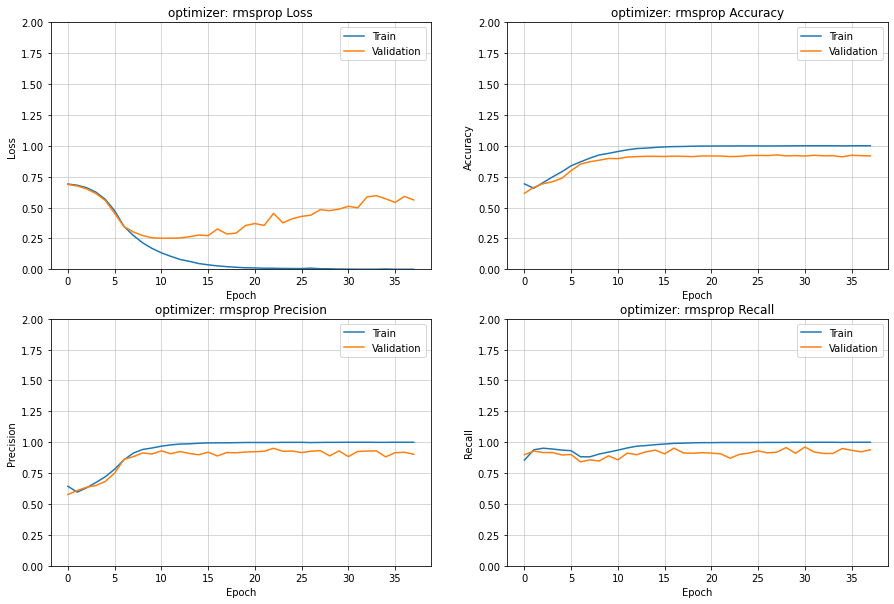

60/60 [==============================] - 0s 8ms/step - loss: 0.5914 - binary_accuracy: 0.7049 - precision: 0.7144 - recall: 0.6974


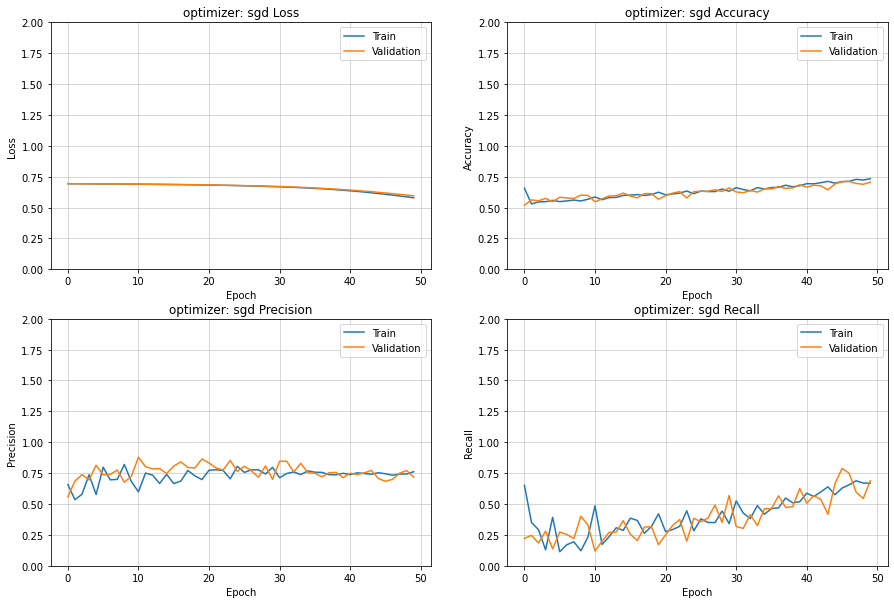

CPU times: user 10min 26s, sys: 40.9 s, total: 11min 7s
Wall time: 11min 24s


In [46]:
%%time
for optimizer in optimizers:
    model = compile_model(initialize_model('gru'), optimizer, 0.0001)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=32,
          validation_split=0.3,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'optimizer: {optimizer}')

#### Results:
##### Best optimizers: Adam and RMSprop

### Testing best learning rate on both optimizers

60/60 [==============================] - 0s 8ms/step - loss: 0.5604 - binary_accuracy: 0.7496 - precision: 0.7598 - recall: 0.7409


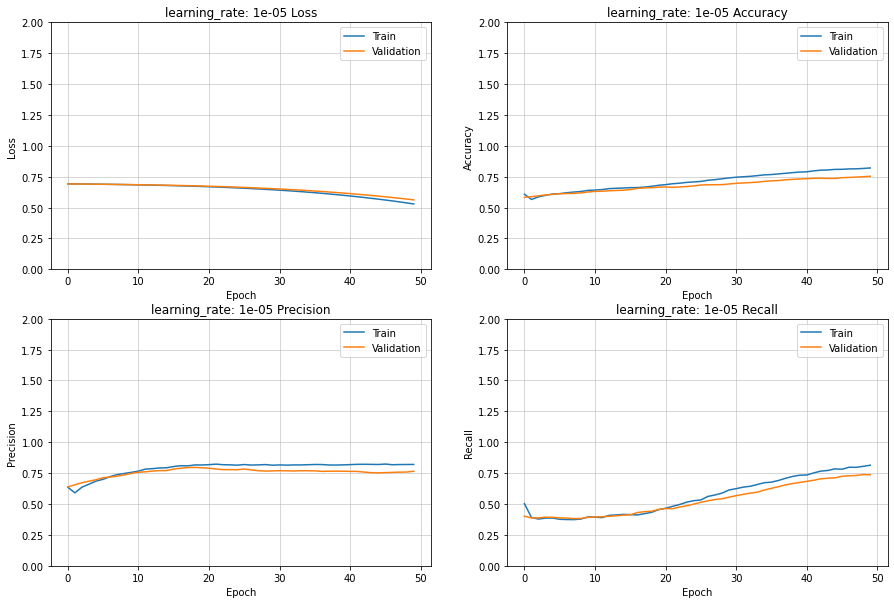

60/60 [==============================] - 0s 8ms/step - loss: 0.3971 - binary_accuracy: 0.9074 - precision: 0.9071 - recall: 0.9109


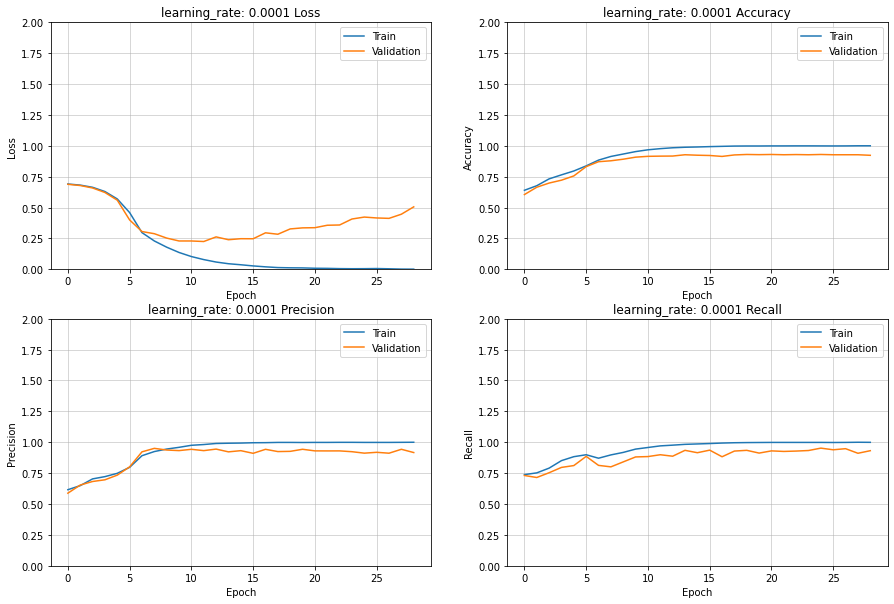

60/60 [==============================] - 1s 10ms/step - loss: 1.0150 - binary_accuracy: 0.8895 - precision: 0.8809 - recall: 0.9047


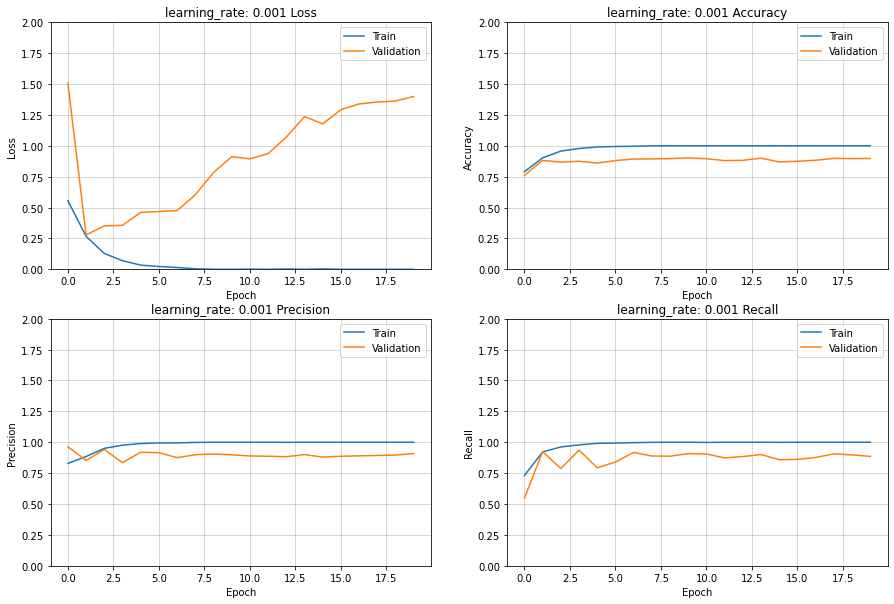

60/60 [==============================] - 1s 10ms/step - loss: 0.3607 - binary_accuracy: 0.8843 - precision: 0.8663 - recall: 0.9130


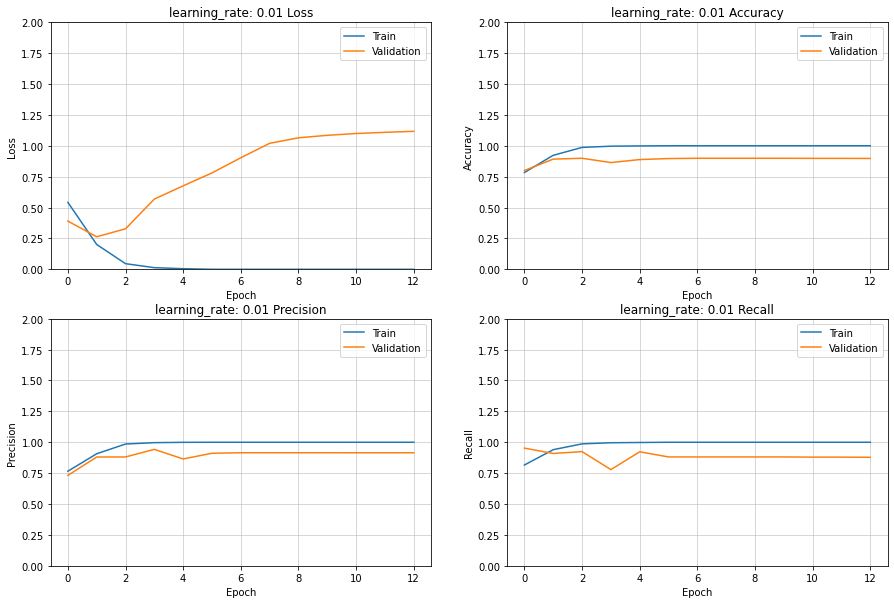

CPU times: user 4min 23s, sys: 17.3 s, total: 4min 41s
Wall time: 4min 2s


In [47]:
%%time
for learning_rate in learning_rates:
    model = compile_model(initialize_model('gru'), 'rmsprop', learning_rate)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=32,
          validation_split=0.3,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'learning_rate: {learning_rate}')

60/60 [==============================] - 0s 8ms/step - loss: 0.3337 - binary_accuracy: 0.8722 - precision: 0.8898 - recall: 0.8539


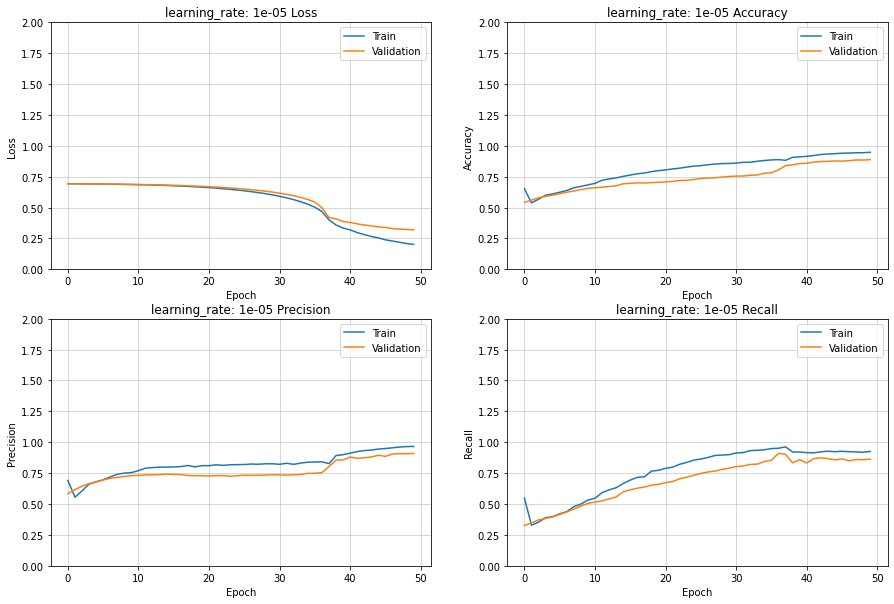

60/60 [==============================] - 1s 10ms/step - loss: 0.4141 - binary_accuracy: 0.9053 - precision: 0.9001 - recall: 0.9150


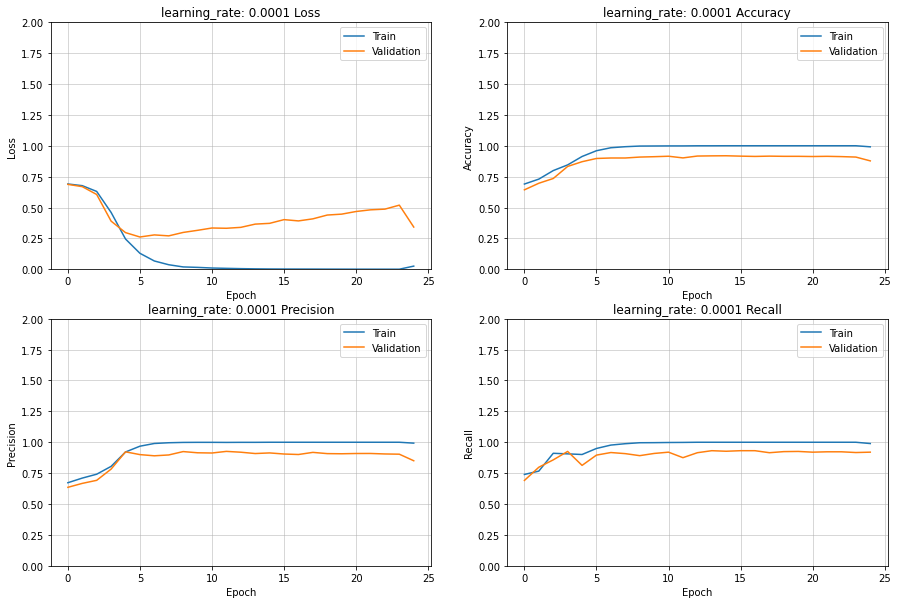

60/60 [==============================] - 1s 10ms/step - loss: 0.4392 - binary_accuracy: 0.8790 - precision: 0.8451 - recall: 0.9326


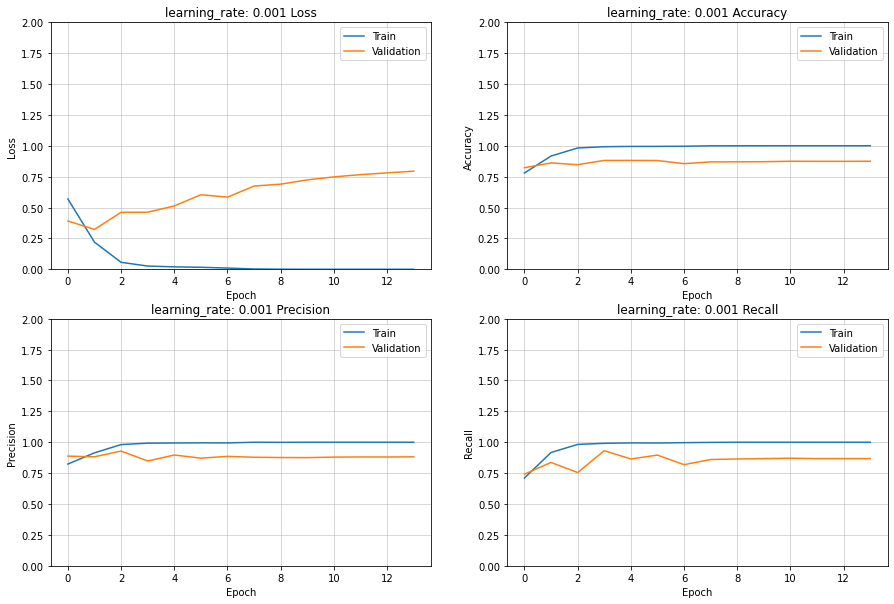

60/60 [==============================] - 0s 8ms/step - loss: 0.8741 - binary_accuracy: 0.8522 - precision: 0.8406 - recall: 0.8746


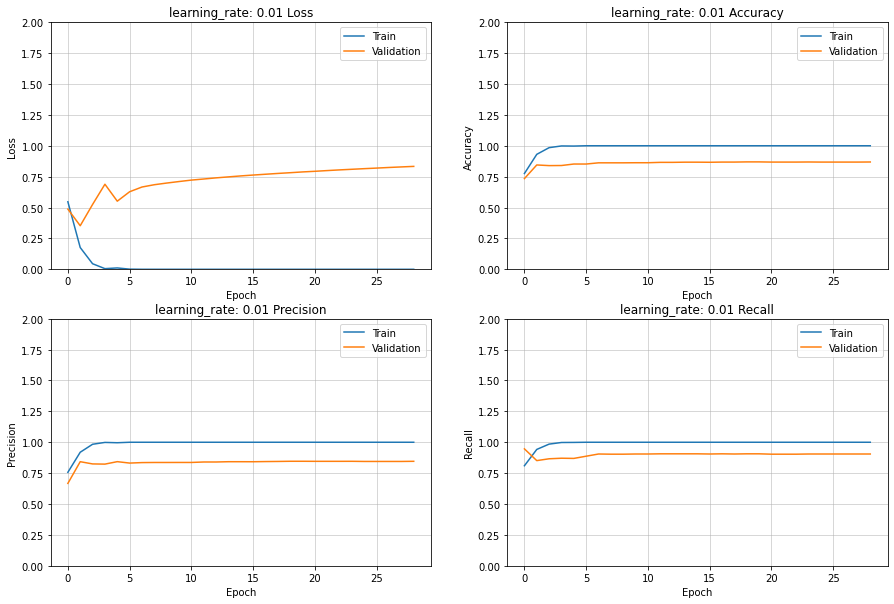

CPU times: user 4min 40s, sys: 17.2 s, total: 4min 57s
Wall time: 4min 50s


In [48]:
%%time
for learning_rate in learning_rates:
    model = compile_model(initialize_model('gru'), 'adam', learning_rate)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=32,
          validation_split=0.3,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, f'learning_rate: {learning_rate}')

#### Results:
##### Best learning rate: 0.0001
###### Best optimizer: rmsprop